# Avoiding the Crash: Navigating the Skies Safely

## Introduction

The aim of this analysis is to determine which aircraft are the lowest risk for a company planning to purchase and operate airplanes for commercial and private enterprises. The dataset includes various factors related to aircraft accidents, and our goal is to provide concrete business recommendations based on this data.

### Stakeholders and Key Business Questions

**Stakeholders:** The head of the new aviation division and company executives.

**Key Business Questions:**
1. Which category of aircraft is the safest to operate?
2. Should the company focus on commercial or private flights?
3. What features of aircraft (e.g., number of engines, engine type) are associated with lower risk?
4. Which aircraft manufacturers produce the safest aircraft?


# Import Python Libraries

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #for spliting some values
%matplotlib inline

# Load the Data

In [2]:
!ls data

AviationData.csv  USState_Codes.csv


In [3]:
#load the CSV files for the rest of the project

#pandas says columns 6, 7, and 28 have mixed data types.  
#For now we will set them to strings to avoid errors later
'''
Latitude and Longitude have two formats in the file.  One is degrees, minutes, seconds format 
with a suffix for hemisphere like N
The other format is called decimal degrees and it is a float.
'''

#latin1 is required as utf-8 will not load
#load 5 rows just for column names, a full load shows mixed data type warnings on columns 6, 7, 28
#so we will tell pandas to load them as strings
aviation_data = pd.read_csv("data/AviationData.csv",encoding="latin1", nrows=1)
col_list = list(aviation_data.columns)
dtype_spec = {
    col_list[6]: 'str', #Latitude
    col_list[7]: 'str', #Longitude
    col_list[28]: 'str' #Broad.phase.of.flight
}

#now load it in full without warnings
aviation_data = pd.read_csv("data/AviationData.csv",encoding="latin1", dtype=dtype_spec)
uscode_data = pd.read_csv("data/USState_Codes.csv")

# Replace string 'nan' with actual np.nan, for ones we forced to load as strings to avoid data type warning
aviation_data = aviation_data.replace('nan', np.nan)

# Initial Data Exploration

In this section we will explore the data and come to understand it

## Standardize Column Names

In [4]:
aviation_data.columns = aviation_data.columns.str.lower().str.replace(' ', '_',regex=False).str.replace('.','_',regex=False)

## Info() and null count

In [5]:
#initial missing data check before cleaning/standardization
null_counts_before_standardization = aviation_data.isnull().sum()
aviation_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_id                88889 non-null  object 
 1   investigation_type      88889 non-null  object 
 2   accident_number         88889 non-null  object 
 3   event_date              88889 non-null  object 
 4   location                88837 non-null  object 
 5   country                 88663 non-null  object 
 6   latitude                34382 non-null  object 
 7   longitude               34373 non-null  object 
 8   airport_code            50249 non-null  object 
 9   airport_name            52790 non-null  object 
 10  injury_severity         87889 non-null  object 
 11  aircraft_damage         85695 non-null  object 
 12  aircraft_category       32287 non-null  object 
 13  registration_number     87572 non-null  object 
 14  make                    88826 non-null

In [6]:
display(max(aviation_data.isna().sum()))
display(aviation_data.isna().sum())

76307

event_id                      0
investigation_type            0
accident_number               0
event_date                    0
location                     52
country                     226
latitude                  54507
longitude                 54516
airport_code              38640
airport_name              36099
injury_severity            1000
aircraft_damage            3194
aircraft_category         56602
registration_number        1317
make                         63
model                        92
amateur_built               102
number_of_engines          6084
engine_type                7077
far_description           56866
schedule                  76307
purpose_of_flight          6192
air_carrier               72241
total_fatal_injuries      11401
total_serious_injuries    12510
total_minor_injuries      11933
total_uninjured            5912
weather_condition          4492
broad_phase_of_flight     27165
report_status              6381
publication_date          13771
dtype: i

## Data Summary

The dataset includes various factors related to aircraft accidents. Below is a brief summary of the key statistics about the dataset:

| Statistic            | Value       |
|----------------------|-------------|
| Number of Rows       | 88889|
| Number of Columns    | 31   |
| Max Nulls in Columns | 76307 |
| Max Null Column      | schedule |
| Initial Exploration  | The dataset covers a wide range of factors related to aircraft accidents, including location, weather conditions, aircraft specifications, and injury severity. |


## Mixed Data Type Issue with Longitude, Latitude

For latitude and longitude they mix formats.  Some are in degrees, minutes and seconds format with a suffix like 'N' for direction.  Some are in decimal degrees, which are easier to work with mathematically.

In [7]:
#To know to pass str types for columns 6, 7 and 28 we had to know what is up with those columns
#We do value_counts to see if one issue comes up a lot and inspect some initial values
aviation_data['latitude'].value_counts()

332739N      19
335219N      18
334118N      17
32.815556    17
324934N      16
             ..
039613N       1
342034N       1
433113N       1
343255N       1
373829N       1
Name: latitude, Length: 25589, dtype: int64

In [8]:
aviation_data['longitude'].value_counts()

0112457W       24
1114342W       18
1151140W       17
-104.673056    17
-112.0825      16
               ..
0843135W        1
0101957W        1
1064131W        1
1114414W        1
0121410W        1
Name: longitude, Length: 27154, dtype: int64

## mixed data type for broad_phase_of_flight 
This is likely due to NaN, but needs more investigation

In [9]:
aviation_data['broad_phase_of_flight'].head()

0      Cruise
1     Unknown
2      Cruise
3      Cruise
4    Approach
Name: broad_phase_of_flight, dtype: object

In [10]:
aviation_data['broad_phase_of_flight'].value_counts()

Landing        15428
Takeoff        12493
Cruise         10269
Maneuvering     8144
Approach        6546
Climb           2034
Taxi            1958
Descent         1887
Go-around       1353
Standing         945
Unknown          548
Other            119
Name: broad_phase_of_flight, dtype: int64

In [11]:
aviation_data['broad_phase_of_flight'].isna().sum()

27165

In [12]:
aviation_data[aviation_data['broad_phase_of_flight'].isna()]['broad_phase_of_flight'].head()

3030    NaN
3550    NaN
3637    NaN
4032    NaN
5505    NaN
Name: broad_phase_of_flight, dtype: object

# Standardize Data

Lets lowercase, and change none or unk or unknown to other values where appropriate from having examined other fields later down the line.

We'll also do more operations on more fields to standardize them.

In [13]:
#lowercase and stripe white space, this removes a lot of duplicate labels
def standardize_string(s):
    if pd.isna(s):
        return s
    if isinstance(s,str):
        s = s.strip().lower()#.replace(' ','_')
    return s

#for some columns treating none as nan helps us do analysis
def none_to_None(s):
    if s == 'none':
        return None #None is the NaN for object columns
    return s

def unknown_to_None(s):
    if s == 'unknown':
        return None
    return s

#for some columns unk is short for unknown but unknown will still be listed, so standardize it
def unk_to_unknown(s):
    if s == 'unk':
        return 'unknown'
    return s

def replace_in_cols(cols,map):
    aviation_data[cols] = aviation_data[cols].applymap(map)


#display(aviation_data.head())
#we are excluding latitude and longitude bc capital N instead of lowercase n is how it is supposed to be
exclude_cols = ['latitude','longitude']
#an array of True and False that will have False for the columns we put in exclude_cols
include_mask = ~aviation_data.columns.isin(exclude_cols)
#loc is used here to target the dataframe columns with the include mask.
#say latitude is the 4th column, the array would have False for the 4th column and that would
#mean pandas doesn't select the 4th column.
#this is just easier than listing all the columns but 2
aviation_data.loc[:,include_mask] = aviation_data.loc[:,include_mask].applymap(standardize_string)

replace_in_cols(['airport_code','airport_name','registration_number'], none_to_None)
replace_in_cols(['aircraft_category','registration_number','engine_type','far_description'], unk_to_unknown)
replace_in_cols(['engine_type','aircraft_damage','registration_number'], unknown_to_None)

#make date strings into datetimes
aviation_data['publication_date'] = pd.to_datetime(aviation_data['publication_date'],format='%d-%m-%Y')

aviation_data.head()

,event_id,investigation_type,accident_number,event_date,location,country,latitude,longitude,airport_code,airport_name,...,purpose_of_flight,air_carrier,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,publication_date
0,20001218x45444,accident,sea87la080,1948-10-24,"moose creek, id",united states,NaN,NaN,NaN,NaN,...,personal,NaN,2.0,0.0,0.0,0.0,unk,cruise,probable cause,NaT
1,20001218x45447,accident,lax94la336,1962-07-19,"bridgeport, ca",united states,NaN,NaN,NaN,NaN,...,personal,NaN,4.0,0.0,0.0,0.0,unk,unknown,probable cause,1996-09-19
2,20061025x01555,accident,nyc07la005,1974-08-30,"saltville, va",united states,36.922223,-81.878056,NaN,NaN,...,personal,NaN,3.0,NaN,NaN,NaN,imc,cruise,probable cause,2007-02-26
3,20001218x45448,accident,lax96la321,1977-06-19,"eureka, ca",united states,NaN,NaN,NaN,NaN,...,personal,NaN,2.0,0.0,0.0,0.0,imc,cruise,probable cause,2000-09-12
4,20041105x01764,accident,chi79fa064,1979-08-02,"canton, oh",united states,NaN,NaN,NaN,NaN,...,personal,NaN,1.0,2.0,NaN,0.0,vmc,approach,probable cause,1980-04-16


## Split injury_severity

The values in parenthesis after make the labels way less useful so we will split them into two new columns.

In [14]:
#split the fatal(123) format into two diff columns
severity = []
number = []
for row in aviation_data['injury_severity']:
    if isinstance(row,str):
        match = re.match(r"(\w+)\((\d+)\)", row)
        if match:
            severity.append(match.group(1))
            number.append(int(match.group(2)))
        else:
            severity.append(row)
            number.append(pd.NA)
    else:
        severity.append(None)
        number.append(pd.NA)

aviation_data['injury_severity_type'] = severity
aviation_data['injury_severity_count'] = number

#converts to int col 
aviation_data['injury_severity_count'] = aviation_data['injury_severity_count'].astype('Int64')

#aviation_data.head()
display(aviation_data[['injury_severity_type','injury_severity_count']])
display(aviation_data['injury_severity_count'])

,injury_severity_type,injury_severity_count
0,fatal,2
1,fatal,4
2,fatal,3
3,fatal,2
4,fatal,1
...,...,...
88884,minor,<NA>
88885,None,<NA>
88886,non-fatal,<NA>
88887,None,<NA>


0           2
1           4
2           3
3           2
4           1
         ... 
88884    <NA>
88885    <NA>
88886    <NA>
88887    <NA>
88888    <NA>
Name: injury_severity_count, Length: 88889, dtype: Int64

## State codes

We may wish to do analysis on the state only so make a new column for it

In [15]:
state_codes = tuple(uscode_data['Abbreviation'].values)
display(uscode_data)
def extract_state(location):
    if pd.notnull(location) and ', ' in location:
        code = location.split(', ')[1].strip().upper()
        if code in state_codes:
            return code
    return None

#split the states into its own column but only if it's 'united states'
#np.where(condition, value if condition is true, value if condition is false)
aviation_data['state'] = np.where(
    aviation_data['country'] == 'united states',
    aviation_data['location'].apply(extract_state),
    None
)

aviation_data['state'].value_counts()

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
...,...,...
57,Virgin Islands,VI
58,Washington_DC,DC
59,Gulf of mexico,GM
60,Atlantic ocean,AO


CA    8857
TX    5913
FL    5825
AK    5672
AZ    2834
CO    2726
WA    2612
IL    2060
MI    2030
GA    2023
NY    1914
OH    1823
PA    1790
OR    1772
NC    1661
MO    1565
WI    1560
AR    1519
MN    1456
ID    1436
NM    1358
UT    1336
IN    1320
VA    1275
OK    1240
NV    1236
LA    1216
NJ    1170
AL    1153
TN    1108
KS    1104
MT    1050
SC     974
MA     969
IA     819
MD     815
MS     813
WY     739
NE     725
KY     650
ND     561
ME     505
CT     502
HI     481
SD     446
WV     394
NH     368
VT     241
RI     158
DE     114
PR     114
GM      44
DC      42
AO      17
PO      14
GU       8
VI       6
Name: state, dtype: int64

## Airport code check
checking for missing values and seeing what kind of data we have


In [16]:
aviation_data['airport_code'].value_counts()

pvt     497
apa     160
ord     149
mri     137
den     115
       ... 
78oh      1
0v6       1
8c3       1
56m       1
eikh      1
Name: airport_code, Length: 10345, dtype: int64

## Fix private variations in airport names

We need to clean the labels so all variations of private are together

In [17]:
replacements = {
    'private airstrip': 'private',
    'private strip': 'private'
}
aviation_data['airport_name'] = aviation_data['airport_name'].replace(replacements)
aviation_data['airport_name'].value_counts()

private                           898
merrill field                     109
centennial                        102
van nuys                           97
north las vegas                    82
                                 ... 
lambert-st. louis int'l             1
williamson mingo cty                1
sanona creek airstrip               1
penns cave                          1
wichita dwight d eisenhower nt      1
Name: airport_name, Length: 21563, dtype: int64

## Compare nulls sum after standardization

In [18]:
null_counts_after_standardization = aviation_data.isnull().sum()
comparison = pd.DataFrame({
    'Before Standardization': null_counts_before_standardization,
    'After Standardization': null_counts_after_standardization
})
#replace_in_cols(['airport_code','airport_name','registration_number'], none_to_nan)
#replace_in_cols(['aircraft_category','registration_number','engine_type','far_description'], unk_to_unknown)
#replace_in_cols(['engine_type','aircraft_damage','registration_number'], unknown_to_nan)
comparison_filtered = comparison[comparison['Before Standardization'] != comparison['After Standardization']]
comparison_filtered

,Before Standardization,After Standardization
aircraft_damage,3194.0,3313
airport_code,38640.0,40252
airport_name,36099.0,36331
engine_type,7077.0,9129
injury_severity_count,NaN,76325
injury_severity_type,NaN,1000
registration_number,1317.0,1752
state,NaN,6756


It looks like we're getting more nulls which is what we wanted in some cases!

In [19]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88889 non-null  object        
 1   investigation_type      88889 non-null  object        
 2   accident_number         88889 non-null  object        
 3   event_date              88889 non-null  object        
 4   location                88837 non-null  object        
 5   country                 88663 non-null  object        
 6   latitude                34382 non-null  object        
 7   longitude               34373 non-null  object        
 8   airport_code            48637 non-null  object        
 9   airport_name            52558 non-null  object        
 10  injury_severity         87889 non-null  object        
 11  aircraft_damage         85576 non-null  object        
 12  aircraft_category       32287 non-null  object

## Far Description

The 'far_description' has a considerably smaller portion of missing data, compared to columns such as 'purpose_of_flight'. Let's investigate these unique values, to see if we can use them to fill other parts of our missing data. 

We'll organize the values as we go, to make them easier to group. 

In [20]:
aviation_data['far_description'].unique()

array([nan, 'part 129: foreign', 'part 91: general aviation',
       'part 135: air taxi & commuter', 'part 125: 20+ pax,6000+ lbs',
       'part 121: air carrier', 'part 137: agricultural',
       'part 133: rotorcraft ext. load', 'unknown',
       'part 91f: special flt ops.', 'non-u.s., non-commercial',
       'public aircraft', 'non-u.s., commercial', 'public use',
       'armed forces', 'part 91 subpart k: fractional', '091', 'nusc',
       '135', 'nusn', '121', '137', '129', '133', '091k', 'pubu', 'armf',
       '103', '125', '437', '107'], dtype=object)

**129** and **part 129: foreign**: Foreign air carriers or operators who would like to conduct passenger or cargo operations to, from, and transiting the US. A foreign air carrier is a person, not a citizen of the U.S., undertaking by any means to provide foreign air transportation. 

**121** and **part 121: air carrier**: Generally large, U.S.-based airlines, regional air carriers, and all cargo operarters.

**non-u.s., commercial**: non-u.s., commercial

**091** and **part 91: general aviation**: General aviation pilots, operating private aircraft. Non-commercial situations only.

**091k** and **part 91 subpart k: fractional**: For private, not-for-hire use by individuals and companies

**135** and **part 135: air taxi & commuter**: For commuter and on-demand operations (flying passengers on-demand, rather than on a scheduled-basis). Can vary from small single aircraft operators, to large operators providing a network to move cargo to larger carriers. Often offer critical services to remote areas.

**125** and **part 125: 20+ pax,6000+ lbs**: Large group charter flight (non-commercial)

**133** and **part 133: rotorcraft ext. load**: On demand, external load air service, where air carriers utilize helicopters

**137** and **part 137: agricultural**: Dispensing any economic poison, other substance or activities dispensed for agriculture, horticulture, or forest preservation.

**public aircraft**: For governmental use only. 

**public use**: "Public" aircrafts are aircrafts used only by the government, however this label could also be referring to a "public use" airport, which would be for commercial purposes. 

**armed forces**: armed forces

**unknown**: unknown

**part 91f: special flt ops.**: Non-commercial flights only.

**non-u.s., non-commercial'**: non-u.s., non-commercial

**nusc**: nusc

**nusn**: nusn

**pubu**: pubu

**armf**: armf

**103**: Ultraleight vehicles. Purely recreational flights.

**437**: Experimental permit using a suborbital rocket

**107**: Small unmanned aircraft systems

In [21]:
#Lets standardize FAR
# Define the function to standardize the far_description
def standardize_description(description):
    if pd.isna(description):
        return description
    if isinstance(description,str):
        description = description.lstrip('0').strip()
        #description = description.replace('subpart k','k').strip()
    if 'part' in description:
        match = re.search(r'part (\d+):', description)
        if match:
            return match.group(1).strip()
    
    return description

# Apply the function row-wise
aviation_data['far_description'] = aviation_data['far_description'].apply(standardize_description)

display(aviation_data['far_description'].value_counts())
display(aviation_data['far_description'].isna().sum())

91                               24707
nusn                              1584
137                               1447
135                               1044
nusc                              1013
121                                844
unknown                            393
129                                346
pubu                               253
133                                139
non-u.s., non-commercial            97
non-u.s., commercial                93
public use                          19
91k                                 14
125                                 10
armf                                 8
107                                  4
public aircraft                      2
103                                  2
armed forces                         1
part 91 subpart k: fractional        1
part 91f: special flt ops.           1
437                                  1
Name: far_description, dtype: int64

56866

## Make 

In [22]:
#we found this in a chart later but we're cleaning it up here
aviation_data['make'] = aviation_data['make'].replace('airbus industrie', 'airbus')

# Checking for Missing Data
First we will run some checks on the aviation_data to see what we're dealing with for missing data

In [23]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88889 non-null  object        
 1   investigation_type      88889 non-null  object        
 2   accident_number         88889 non-null  object        
 3   event_date              88889 non-null  object        
 4   location                88837 non-null  object        
 5   country                 88663 non-null  object        
 6   latitude                34382 non-null  object        
 7   longitude               34373 non-null  object        
 8   airport_code            48637 non-null  object        
 9   airport_name            52558 non-null  object        
 10  injury_severity         87889 non-null  object        
 11  aircraft_damage         85576 non-null  object        
 12  aircraft_category       32287 non-null  object

It seems we are missing a lot of data!  We will need to formulate plans on all of this.
This next code block will let us see how much data is missing percent wise

## Missing Percent

To analyse useful columns we will see what percent of the data is missing for each column

In [24]:
# Calculate the percentage of missing values for each column
missing_perc = aviation_data.isna().mean() * 100
missing_perc

event_id                   0.000000
investigation_type         0.000000
accident_number            0.000000
event_date                 0.000000
location                   0.058500
country                    0.254250
latitude                  61.320298
longitude                 61.330423
airport_code              45.283443
airport_name              40.872324
injury_severity            1.124999
aircraft_damage            3.727120
aircraft_category         63.677170
registration_number        1.970998
make                       0.070875
model                      0.103500
amateur_built              0.114750
number_of_engines          6.844491
engine_type               10.270112
far_description           63.974170
schedule                  85.845268
purpose_of_flight          6.965991
air_carrier               81.271023
total_fatal_injuries      12.826109
total_serious_injuries    14.073732
total_minor_injuries      13.424608
total_uninjured            6.650992
weather_condition          5

Convention suggests dropping columns where over 50% of the data is missing, unless it is very important to your analysis.
These are candidates to consider dropping:

In [25]:
missing_perc[missing_perc > 50]

latitude                 61.320298
longitude                61.330423
aircraft_category        63.677170
far_description          63.974170
schedule                 85.845268
air_carrier              81.271023
injury_severity_count    85.865518
dtype: float64

## location

Lets see what Location has, maybe it will help us decide on what to do with Lat and Long

In [26]:
aviation_data['location'].value_counts()

anchorage, ak       548
miami, fl           275
houston, tx         271
albuquerque, nm     265
chicago, il         256
                   ... 
medina, mn            1
circle pines, mn      1
pine island, fl       1
churchtown, oh        1
brasnorte,            1
Name: location, Length: 21977, dtype: int64

We have options now, we can drop Lat and Long or we can use some sort of API to get the Lat and Long filled based on the Locatoin when it is missing!  We don't have to decide now, lets let further exploration guide our choices.

# Exploring More Columns

## investigation_type

In [27]:
aviation_data['investigation_type'].value_counts()

accident    85015
incident     3874
Name: investigation_type, dtype: int64

Accident - caused personal injury, damage or damage
Incident - could have potentially caused harm but didn't necessarily 

Weighting these differently is a good idea.

## country

In [28]:
aviation_data['country'].value_counts()

united states     82248
brazil              374
canada              359
mexico              358
united kingdom      344
                  ...  
chad                  1
ivory coast           1
cambodia              1
yemen                 1
benin                 1
Name: country, Length: 215, dtype: int64

There is a strong bias to the United States so our data is only going to be the most reliable in the US due to uncontrolled factors like regulation differences between countries.

## airport_code and airport_name

In [29]:
aviation_data['airport_code'].value_counts()

pvt     497
apa     160
ord     149
mri     137
den     115
       ... 
78oh      1
0v6       1
8c3       1
56m       1
eikh      1
Name: airport_code, Length: 10345, dtype: int64

In [30]:
aviation_data['airport_name'].value_counts()

private                           898
merrill field                     109
centennial                        102
van nuys                           97
north las vegas                    82
                                 ... 
lambert-st. louis int'l             1
williamson mingo cty                1
sanona creek airstrip               1
penns cave                          1
wichita dwight d eisenhower nt      1
Name: airport_name, Length: 21563, dtype: int64

We will have to clean the names quite a bit especially around private airports.
The codes have a lot of missing data could that correlate with private airports not having codes?


In [31]:
aviation_data[(aviation_data['airport_name']=='private') & (aviation_data['airport_code'].isna())][['airport_name','airport_code']]

,airport_name,airport_code
64,private,NaN
182,private,NaN
225,private,NaN
270,private,NaN
730,private,NaN
...,...,...
87442,private,None
87470,private,NaN
87887,private,NaN
88425,private,NaN


In [32]:
aviation_data[(aviation_data['airport_name']=='private') & (aviation_data['airport_code'].notna())][['airport_code']].value_counts()

airport_code
pvt             182
priv              6
xxx               4
unk               2
rla               2
0                 1
x                 1
unkn              1
rrdi              1
nowr              1
n\a               1
my99              1
-                 1
ipy               1
999               1
4nc5              1
2az1              1
172               1
12                1
0co6              1
0c09              1
04il              1
00al              1
mm20              1
dtype: int64

In [33]:
aviation_data[aviation_data['airport_name']=='private']['airport_name'].count()

898

## Injury Severity Check

In [34]:
aviation_data['injury_severity'].value_counts()

non-fatal     67357
fatal(1)       6167
fatal          5262
fatal(2)       3711
incident       2219
              ...  
fatal(270)        1
fatal(60)         1
fatal(43)         1
fatal(143)        1
fatal(230)        1
Name: injury_severity, Length: 109, dtype: int64

We already separated these and they are left untouched in their column

## aircraft_damage

In [35]:
aviation_data['aircraft_damage'].value_counts()

substantial    64148
destroyed      18623
minor           2805
Name: aircraft_damage, dtype: int64

In [36]:
aviation_data['aircraft_damage'].isna().sum()

3313

Finally a field that has little issues, just a few missing values.

## Aircraft Specs
Lets examine the group of fields that might let us identify features of the airplanes, some of the most important data

### aircraft_category

In [37]:
aviation_data['aircraft_category'].value_counts()

airplane             27617
helicopter            3440
glider                 508
balloon                231
gyrocraft              173
weight-shift           161
powered parachute       91
ultralight              30
unknown                 16
wsft                     9
powered-lift             5
blimp                    4
rocket                   1
ultr                     1
Name: aircraft_category, dtype: int64

We can get rid of all that aren't airplane, probably

### registration_number

In [38]:
aviation_data['registration_number'].value_counts()

unreg     131
usaf        9
n20752      8
n53893      6
n11vh       6
         ... 
n62951      1
n1013e      1
n8266r      1
n65737      1
n9026p      1
Name: registration_number, Length: 79091, dtype: int64

Lots of NONE might not be as useful a field.  However if some planes were just train wrecks and had lots of issues then they could be 
something worth keeping in mind when interpretting the data
### make

In [39]:
aviation_data['make'].value_counts()

cessna           27149
piper            14870
beech             5372
boeing            2745
bell              2722
                 ...  
cohen                1
kitchens             1
lutes                1
izatt                1
royse ralph l        1
Name: make, Length: 7586, dtype: int64

We will need to clean this data for sure the Cessna for example is listed twice with diff capitilization
Note: It will not show up twice here now because we have already standarized capilization 

### model

In [40]:
aviation_data['model'].value_counts()

152                 2367
172                 1756
172n                1164
pa-28-140            932
150                  829
                    ... 
e75nl                  1
747-273c               1
watcha-mccall-it       1
md-520n                1
m-8 eagle              1
Name: model, Length: 11646, dtype: int64

Make and Model together can form unique strings to identify types of craft so this is nice.  (It is possible for a model to have the same name and diff makes, even if rare).  This pair will be used in a lot of finding the correlations in the data.
## amateur_built

In [41]:
aviation_data['amateur_built'].value_counts()

no     80312
yes     8475
Name: amateur_built, dtype: int64

Since we are a business we might just remove rows about amateur built aircraft.  However maybe some of the non business made ones have properties we'd be interested in?

In [42]:
aviation_data['number_of_engines'].value_counts()

1.0    69582
2.0    11079
0.0     1226
3.0      483
4.0      431
8.0        3
6.0        1
Name: number_of_engines, dtype: int64

I'm wondering what has zero engines, gliders perhaps?  Lets find out below

In [43]:
aviation_data[aviation_data['number_of_engines']==0][['engine_type']].value_counts()

engine_type  
none             10
reciprocating     2
dtype: int64

In [44]:
aviation_data[aviation_data['number_of_engines']==0][['make','model','aircraft_category','engine_type']]

,make,model,aircraft_category,engine_type
62,schleicher,asw 20,glider,None
247,raven,s-55a,balloon,None
353,balloon works,firefly,balloon,None
433,barnes,firefly-7,balloon,None
436,barnes,balloon ax7,balloon,None
...,...,...,...,...
88322,schleicher,asw-20b,glider,none
88462,schweizer,sgs 2-33a,glider,NaN
88476,firefly balloons,firefly 8b-15,balloon,NaN
88596,schleicher,asw-20,glider,NaN


balloons and gliders!

In [45]:
aviation_data['engine_type'].value_counts()

reciprocating      69530
turbo shaft         3609
turbo prop          3391
turbo fan           2481
turbo jet            703
none                  21
geared turbofan       12
electric              10
lr                     2
hybrid rocket          1
Name: engine_type, dtype: int64

That's a lot of bias on Reciprocating!

## far_description
FAR stands for Federal Aviation Regulations. These regulations are a comprehensive set of rules and guidelines established by the Federal Aviation Administration (FAA) to ensure the safety and efficiency of civil aviation within the United States.

Some examples:
- Part 23: Airworthiness Standards for Normal, Utility, Acrobatic, and Commuter Category Airplanes
- Part 61: Certification: Pilots, Flight Instructors, and Ground Instructors
- Part 91: General Operating and Flight Rules
- Part 121: Operating Requirements: Domestic, Flag, and Supplemental Operations

In [46]:
aviation_data['far_description'].value_counts()

91                               24707
nusn                              1584
137                               1447
135                               1044
nusc                              1013
121                                844
unknown                            393
129                                346
pubu                               253
133                                139
non-u.s., non-commercial            97
non-u.s., commercial                93
public use                          19
91k                                 14
125                                 10
armf                                 8
107                                  4
public aircraft                      2
103                                  2
armed forces                         1
part 91 subpart k: fractional        1
part 91f: special flt ops.           1
437                                  1
Name: far_description, dtype: int64

The Data for this will need standardized as seen by the Part 91 and etc.  
on part 91 and others
https://pilotinstitute.com/part-91-vs-121-vs-135/

NUSN: Non-U.S. National (incident or accident)

"NUSN" is a code used to identify incidents or accidents involving aircraft that are not registered in the United States. This categorization helps in distinguishing between domestic and international incidents for regulatory and statistical purposes.
NUSC: Non-U.S. Commercial (incident or accident)

"NUSC" refers to incidents or accidents involving non-U.S. commercial aircraft. This code is specifically used for commercial operations, such as airlines and charter services, that are not registered in the United States.

... Understanding all the codes is going to be important if we use this field

## schedule

In [47]:
aviation_data['schedule'].value_counts()

nsch    4474
unk     4099
schd    4009
Name: schedule, dtype: int64

NSCH (Non-Scheduled): Refers to flights that do not operate on a regular schedule. These can include charter flights, air taxi operations, private flights, and other ad-hoc operations.

UNK (Unknown): Indicates that the schedule type of the flight operation is unknown. This can occur when the information is not available or not recorded in the safety database.

SCHD (Scheduled): Refers to flights that operate on a regular, published schedule. These are typically commercial airline flights that follow a fixed timetable.

## purpose_of_flight

In [48]:
aviation_data['purpose_of_flight'].value_counts()

personal                     49448
instructional                10601
unknown                       6802
aerial application            4712
business                      4018
positioning                   1646
other work use                1264
ferry                          812
aerial observation             794
public aircraft                720
executive/corporate            553
flight test                    405
skydiving                      182
external load                  123
public aircraft - federal      105
banner tow                     101
air race show                   99
public aircraft - local         74
public aircraft - state         64
air race/show                   59
glider tow                      53
firefighting                    40
air drop                        11
asho                             6
pubs                             4
publ                             1
Name: purpose_of_flight, dtype: int64

This is very informative as a field and it seems to have minimal issues with missing data.  Here is the Skydiving Joseph mentioned.

## air_carrier

In [49]:
aviation_data['air_carrier'].value_counts()

pilot                         258
american airlines              90
united airlines                89
delta air lines                53
delta air lines inc            44
                             ... 
frank w. scooley                1
richard l. mcglashan            1
inflight pilot traning llc      1
mills & daughters inc           1
mc cessna 210n llc              1
Name: air_carrier, Length: 13208, dtype: int64

It has a lot of missing rows but it could have a big impact on safety.
We will avoid fixing things like combining delta air lines inc with delta air lines though unless we end up using the field

## total_fatal_injuries

In [50]:
aviation_data['total_fatal_injuries'].value_counts()

0.0      59675
1.0       8883
2.0       5173
3.0       1589
4.0       1103
         ...  
156.0        1
68.0         1
31.0         1
115.0        1
176.0        1
Name: total_fatal_injuries, Length: 125, dtype: int64

it is in floats for some reason so we might make sure there's no "partial fatal injuries"

## total_serious_injuries

In [51]:
aviation_data['total_serious_injuries'].value_counts()

0.0      63289
1.0       9125
2.0       2815
3.0        629
4.0        258
5.0         78
6.0         41
7.0         27
9.0         16
10.0        13
8.0         13
13.0         9
11.0         6
26.0         5
14.0         5
12.0         5
20.0         3
25.0         3
28.0         3
21.0         2
59.0         2
50.0         2
17.0         2
47.0         2
137.0        1
19.0         1
161.0        1
27.0         1
35.0         1
67.0         1
33.0         1
88.0         1
125.0        1
53.0         1
34.0         1
41.0         1
18.0         1
63.0         1
55.0         1
23.0         1
43.0         1
39.0         1
45.0         1
44.0         1
16.0         1
60.0         1
106.0        1
81.0         1
15.0         1
22.0         1
Name: total_serious_injuries, dtype: int64

It is in floats again
## total_minor_injuries

In [52]:
aviation_data['total_minor_injuries'].value_counts()

0.0      61454
1.0      10320
2.0       3576
3.0        784
4.0        372
5.0        129
6.0         67
7.0         59
9.0         22
8.0         20
13.0        14
10.0        11
12.0        11
14.0        10
11.0         9
17.0         8
19.0         6
18.0         6
24.0         5
22.0         5
25.0         4
16.0         4
15.0         4
33.0         4
20.0         3
21.0         3
26.0         3
23.0         3
32.0         3
27.0         3
50.0         2
30.0         2
36.0         2
31.0         2
28.0         2
42.0         2
38.0         2
57.0         1
65.0         1
84.0         1
43.0         1
35.0         1
380.0        1
47.0         1
68.0         1
200.0        1
71.0         1
58.0         1
171.0        1
39.0         1
96.0         1
29.0         1
69.0         1
62.0         1
45.0         1
125.0        1
40.0         1
Name: total_minor_injuries, dtype: int64

It is in floats again
## total_uninjured

In [53]:
aviation_data['total_uninjured'].value_counts()

0.0      29879
1.0      25101
2.0      15988
3.0       4313
4.0       2662
         ...  
558.0        1
412.0        1
338.0        1
401.0        1
455.0        1
Name: total_uninjured, Length: 379, dtype: int64

also in floats
## weather_condition

In [54]:
aviation_data['weather_condition'].value_counts()

vmc    77303
imc     5976
unk     1118
Name: weather_condition, dtype: int64

UNK and Unk are not standardized, (Note they are after we standaridized capitilizaton)

Conditions are codes:

**VMC (Visual Meteorological Conditions):**

VMC: Indicates weather conditions that allow for visual flight rules (VFR) operations. Pilots can navigate and control the aircraft using visual references outside the cockpit.

**IMC (Instrument Meteorological Conditions):**

IMC: Refers to weather conditions that require instrument flight rules (IFR) operations. Visibility and cloud cover are such that pilots must rely on cockpit instruments for navigation and control.

**UNK (Unknown):**

UNK: Indicates that the meteorological conditions at the time of the incident or data point are unknown or not recorded.


## broad_phase_of_flight

In [55]:
aviation_data['broad_phase_of_flight'].value_counts()

landing        15428
takeoff        12493
cruise         10269
maneuvering     8144
approach        6546
climb           2034
taxi            1958
descent         1887
go-around       1353
standing         945
unknown          548
other            119
Name: broad_phase_of_flight, dtype: int64

Landing is the most prone to incident or accident it seems like, especially since it is also relatively short in terms of phases.
This data can help us find planes weak points and strong points as well as high risk areas.

## report_status

In [56]:
aviation_data['report_status'].value_counts()

probable cause                                                                                                                                                                                                                                      61754
foreign                                                                                                                                                                                                                                              1999
<br /><br />                                                                                                                                                                                                                                          167
factual                                                                                                                                                                                                                                               145


So it seems a lot of the values are probable cause

**Probable Cause**: This term is used to describe the findings of an investigation that identify the factors or events that most likely led to the incident or accident. When a report reaches the "probable cause" status, the investigating authority, such as the National Transportation Safety Board (NTSB) in the United States, has completed its analysis and has determined the primary reasons behind the occurrence.


## publication_date

In [57]:
aviation_data['publication_date'].value_counts()

2020-09-25    17019
2020-09-26     1769
2020-11-03     1155
1993-03-31      452
2003-11-25      396
              ...  
2004-11-29        1
2001-08-29        1
2004-11-18        1
1996-12-17        1
2022-12-29        1
Name: publication_date, Length: 2924, dtype: int64

## Event Date
We're going to cut out years with less than 100 accidents

In [58]:
aviation_data['event_date'].unique()

array(['1948-10-24', '1962-07-19', '1974-08-30', ..., '2022-12-22',
       '2022-12-26', '2022-12-29'], dtype=object)

In [59]:
#convert 'event_date' to datetime formart
aviation_data['event_date'] = pd.to_datetime(aviation_data['event_date'])
aviation_data['year'] = aviation_data['event_date'].dt.year

display(aviation_data['year'].max())
display(aviation_data['year'].min())
year_counts = aviation_data['year'].value_counts()
display(year_counts)

# Drop years where the value count is less than 100
aviation_data = aviation_data[aviation_data['year'].isin(year_counts[year_counts >= 100].index)]
display(aviation_data['year'].max())
display(aviation_data['year'].min())
display(aviation_data['year'].value_counts())

2022

1948

1982    3593
1983    3556
1984    3457
1985    3096
1986    2880
1987    2828
1988    2730
1989    2544
1990    2518
1991    2462
1992    2355
1993    2313
1995    2309
1994    2257
1998    2226
2000    2220
1999    2209
1996    2187
1997    2148
2003    2085
2001    2063
2005    2031
2002    2020
2007    2016
2004    1952
2008    1893
2006    1851
2011    1850
2012    1835
2010    1786
2009    1783
2018    1681
2016    1664
2017    1638
2019    1624
2022    1607
2015    1582
2013    1561
2021    1545
2014    1535
2020    1392
1979       2
1962       1
1981       1
1977       1
1974       1
1948       1
Name: year, dtype: int64

2022

1982

1982    3593
1983    3556
1984    3457
1985    3096
1986    2880
1987    2828
1988    2730
1989    2544
1990    2518
1991    2462
1992    2355
1993    2313
1995    2309
1994    2257
1998    2226
2000    2220
1999    2209
1996    2187
1997    2148
2003    2085
2001    2063
2005    2031
2002    2020
2007    2016
2004    1952
2008    1893
2006    1851
2011    1850
2012    1835
2010    1786
2009    1783
2018    1681
2016    1664
2017    1638
2019    1624
2022    1607
2015    1582
2013    1561
2021    1545
2014    1535
2020    1392
Name: year, dtype: int64

it's really weird that publication date is grouped so much on 2020-09-25
we either need to understand why and try to figure out a use for it, or just use another date field which
seems far more useful

# Describe and Identify Outliers

In [60]:
aviation_data.describe()

,number_of_engines,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,injury_severity_count,year
count,82799.000000,77482.000000,76374.000000,76951.000000,82971.000000,12558.000000,88882.00000
mean,1.146584,0.647699,0.279873,0.357071,5.325294,2.834926,1999.20885
std,0.446515,5.486135,1.544120,2.235695,27.914290,11.236838,11.88572
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1982.00000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1989.00000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1998.00000
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2009.00000
max,8.000000,349.000000,161.000000,380.000000,699.000000,349.000000,2022.00000


Looking at the description of the numerical data in our dataset, there are a few things of note...

**The first three quartiles** of total_fatal_injuries, total_serious_injuries, and total_minor_injuries, are all equal to zero. Yet the **max** of these three categories are comparably high numbers. A similar data skew is true for 'total_uninjured'. These are outliers that can either be helpful or hurtful to consider in our analysis.

In this instance, outliers are particularly useful because they point to aircrafts with higher cases of risk.

Outliers mean that the best measure of central tendency to use when filling in missing values is probably the **median**

# Filtering Data

There is a lot duplicate and unecessary data. Before we can figure out how to best group the items in our dataset, we need to filter out some of the unecessary information

In [61]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88882 entries, 7 to 88888
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88882 non-null  object        
 1   investigation_type      88882 non-null  object        
 2   accident_number         88882 non-null  object        
 3   event_date              88882 non-null  datetime64[ns]
 4   location                88830 non-null  object        
 5   country                 88656 non-null  object        
 6   latitude                34380 non-null  object        
 7   longitude               34371 non-null  object        
 8   airport_code            48637 non-null  object        
 9   airport_name            52558 non-null  object        
 10  injury_severity         87882 non-null  object        
 11  aircraft_damage         85569 non-null  object        
 12  aircraft_category       32286 non-null  object

#### Geographic Location

**Longitude and Latitude**: We don't need 'longitude' and 'latitude', we can just use 'location' column for our findings.

In [62]:
#Drop the latitude and longitude columns
aviation_data.drop(columns=['latitude', 'longitude'], inplace=True)

#### Date and Time

**Publication Date**: The publication date is also uncessary. We have other time markers that will be far more relevant to the aim of our investigation.

In [63]:
#'publication_date' is unecessary to our analysis.
#Error when reformatting notebook, so must add blank column, to be able to note dropping it
#aviation_data['publication_date'] = 0
aviation_data.drop(columns=['publication_date'], inplace=True)

#### Summary Statistics - Injury Severity

We need to find a way to quanitify the injuries per accident. To do so, we have to further categorize and clean the data.

In [64]:
#Investigating necessity of columns

print('Unique categories in injury_severity:', aviation_data['injury_severity'].unique())
print('Unique categories in injury_severity_type:', aviation_data['injury_severity_type'].unique())
print('Unique categories in injury_severity_count:', aviation_data['injury_severity_count'].unique())

Unique categories in injury_severity: ['non-fatal' 'fatal(1)' 'fatal(2)' 'fatal(3)' 'incident' 'fatal(8)'
 'fatal(4)' 'fatal(78)' 'fatal(7)' 'fatal(6)' 'fatal(5)' 'fatal(153)'
 'fatal(12)' 'fatal(14)' 'fatal(23)' 'fatal(10)' 'fatal(11)' 'fatal(9)'
 'fatal(17)' 'fatal(13)' 'fatal(29)' 'fatal(70)' 'unavailable'
 'fatal(135)' 'fatal(31)' 'fatal(256)' 'fatal(25)' 'fatal(82)'
 'fatal(156)' 'fatal(28)' 'fatal(18)' 'fatal(43)' 'fatal(15)' 'fatal(270)'
 'fatal(144)' 'fatal(174)' 'fatal(111)' 'fatal(131)' 'fatal(20)'
 'fatal(73)' 'fatal(27)' 'fatal(34)' 'fatal(87)' 'fatal(30)' 'fatal(16)'
 'fatal(47)' 'fatal(56)' 'fatal(37)' 'fatal(132)' 'fatal(68)' 'fatal(54)'
 'fatal(52)' 'fatal(65)' 'fatal(72)' 'fatal(160)' 'fatal(189)'
 'fatal(123)' 'fatal(33)' 'fatal(110)' 'fatal(230)' 'fatal(97)'
 'fatal(349)' 'fatal(125)' 'fatal(35)' 'fatal(228)' 'fatal(75)'
 'fatal(104)' 'fatal(229)' 'fatal(80)' 'fatal(217)' 'fatal(169)'
 'fatal(88)' 'fatal(19)' 'fatal(60)' 'fatal(113)' 'fatal(143)' 'fatal(83)'
 'fatal(

Before diving in deeper...Since we made our injury severity 'type' and 'count' columns, we can drop 'injury_severity'.

In [65]:
#Dropping column
aviation_data.drop(columns=['injury_severity'], inplace=True)

## Make and Model

Due to the outliers in the data, we know that our mean will be skewed. So we should probably use the median to fill in these missing values. 
However, to have an even more detailed analysis, we can **group the accidents by make and model** and filter imputations through these groupings. Then we can imputate the missing values using the **mean or mode** of these groupings.

Before we do so, we must deal with the missing data in these columns. 

Let's remind ourselves of how much data is missing in the 'make' and 'model' columns.

In [66]:
aviation_data['make'].isna().sum()

63

In [67]:
aviation_data['model'].isna().sum()

92

Since there aren't that many missing values, we can just drop those rows.

In [68]:
aviation_data.dropna(subset=['make', 'model'], inplace=True)

print('Number of missing values in make:', aviation_data['make'].isna().sum())
print('Number of missing values in model:', aviation_data['model'].isna().sum())

Number of missing values in make: 0
Number of missing values in model: 0


## Concatenate Make and Model

Create a new column that specifies an aircrafts 'make_and_model', accounting for different model types across the same make.

Doing this ensures we don't have the same model number on multiple makes, confusing our imputation.  Though rare it does happen.

In [69]:
aviation_data['make_model'] = aviation_data['make'] + '-' + aviation_data['model']
display(aviation_data.head())
display(aviation_data['make_model'].isna().sum())
display(aviation_data['make_model'].value_counts())

,event_id,investigation_type,accident_number,event_date,location,country,airport_code,airport_name,aircraft_damage,aircraft_category,...,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,injury_severity_type,injury_severity_count,state,year,make_model
7,20020909x01562,accident,sea82da022,1982-01-01,"pullman, wa",united states,NaN,blackburn ag strip,substantial,airplane,...,0.0,2.0,vmc,takeoff,probable cause,non-fatal,<NA>,WA,1982,cessna-140
8,20020909x01561,accident,nyc82da015,1982-01-01,"east hanover, nj",united states,n58,hanover,substantial,airplane,...,0.0,2.0,imc,landing,probable cause,non-fatal,<NA>,NJ,1982,cessna-401b
9,20020909x01560,accident,mia82da029,1982-01-01,"jacksonville, fl",united states,jax,jacksonville intl,substantial,NaN,...,3.0,0.0,imc,cruise,probable cause,non-fatal,<NA>,FL,1982,north american-navion l-17b
10,20020909x01559,accident,ftw82da034,1982-01-01,"hobbs, nm",united states,NaN,NaN,substantial,NaN,...,0.0,1.0,vmc,approach,probable cause,non-fatal,<NA>,NM,1982,piper-pa-28-161
11,20020909x01558,accident,atl82dkj10,1982-01-01,"tuskegee, al",united states,NaN,tuskegee,substantial,NaN,...,0.0,1.0,vmc,landing,probable cause,non-fatal,<NA>,AL,1982,beech-v35b


0

cessna-152               2366
cessna-172               1753
cessna-172n              1163
piper-pa-28-140           932
cessna-150                829
                         ... 
spencer-pitts s-1s          1
wolf-smith m/p dsa-1        1
boeing-737-548              1
corben-junior ace           1
royse ralph l-glasair       1
Name: make_model, Length: 18223, dtype: int64

## Set 0 to nan for number of engines
Since we aren't interested in balloons or gliders this will make some things easier.

In [70]:
aviation_data.loc[aviation_data['number_of_engines'] == 0, 'number_of_engines'] = np.nan

## Cleaning Data Types

Before we go on, let's make all our numerical objects be ints unless they require being float.

Let's check whether or not we need float objects, as opposed to integer objects, by filtering out floats that end with a decimal point other than ".0"

This will ensure there are no aircrafts built with entities such as "half-engines", or accidents with "half-fatalities".

### Show float columns

In [71]:
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88770 entries, 7 to 88888
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88770 non-null  object        
 1   investigation_type      88770 non-null  object        
 2   accident_number         88770 non-null  object        
 3   event_date              88770 non-null  datetime64[ns]
 4   location                88718 non-null  object        
 5   country                 88545 non-null  object        
 6   airport_code            48602 non-null  object        
 7   airport_name            52514 non-null  object        
 8   aircraft_damage         85479 non-null  object        
 9   aircraft_category       32244 non-null  object        
 10  registration_number     87068 non-null  object        
 11  make                    88770 non-null  object        
 12  model                   88770 non-null  object

### Find floats in float cols or can they all be int?

In [72]:

float_cols = aviation_data.select_dtypes(include=['float64']).columns
display(float_cols)

#uncomment to check code, but then rerun all up to this cell when done
#aviation_data['number_of_engines'] = 1.1
# Iterate over each float column
for col in float_cols:
    print(f"Column: {col}")
    # Check and print values that are not integers
    #it will return a series of True and False based on if it's both not nan and float != int of the same number
    non_int_values = aviation_data[col][aviation_data[col].apply(lambda x: not np.isnan(x) and x != int(x))]
    if not non_int_values.empty:
        print("Non-integer values:")
        print(non_int_values)
    else:
        print("All values are integers.")
    print()

Index(['number_of_engines', 'total_fatal_injuries', 'total_serious_injuries',
       'total_minor_injuries', 'total_uninjured'],
      dtype='object')

Column: number_of_engines
All values are integers.

Column: total_fatal_injuries
All values are integers.

Column: total_serious_injuries
All values are integers.

Column: total_minor_injuries
All values are integers.

Column: total_uninjured
All values are integers.



### Convert cols to Int64 which allows null values

In [73]:
#since they are all integers lets convert the column
for col in float_cols:
    aviation_data[col] = aviation_data[col].astype('Int64')
aviation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88770 entries, 7 to 88888
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   event_id                88770 non-null  object        
 1   investigation_type      88770 non-null  object        
 2   accident_number         88770 non-null  object        
 3   event_date              88770 non-null  datetime64[ns]
 4   location                88718 non-null  object        
 5   country                 88545 non-null  object        
 6   airport_code            48602 non-null  object        
 7   airport_name            52514 non-null  object        
 8   aircraft_damage         85479 non-null  object        
 9   aircraft_category       32244 non-null  object        
 10  registration_number     87068 non-null  object        
 11  make                    88770 non-null  object        
 12  model                   88770 non-null  object

## More filtering validation

In [74]:
# Ensure that filtering based on number of engines is correct
filtered_data = aviation_data[aviation_data['number_of_engines'] >= 2]
print(f"Remaining records after filtering for number of engines >= 2: {filtered_data.shape[0]}")
print(f"Filtered out records: {aviation_data.shape[0] - filtered_data.shape[0]}")


Remaining records after filtering for number of engines >= 2: 11989
Filtered out records: 76781


# Impute

In [75]:
aviation_data['purpose_of_flight'] = aviation_data['purpose_of_flight'].replace('unknown', np.nan)

aviation_data[aviation_data['commercial_or_private'] == 'commercial'][['make','model','commercial_or_private','purpose_of_flight']]

KeyError: 'commercial_or_private'

## Impute Aircraft Features based on make_model
some pre output to make sure it works

In [ ]:
aviation_data[aviation_data['make_model']=='cessna-310r']['number_of_engines'].value_counts()

2    110
1      2
Name: number_of_engines, dtype: Int64

In [ ]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].isna().sum()

10

In [ ]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].value_counts()

reciprocating    109
Name: engine_type, dtype: int64

In [ ]:
aviation_data['aircraft_category'].value_counts()

airplane             27579
helicopter            3435
glider                 508
balloon                231
gyrocraft              173
weight-shift           161
powered parachute       91
ultralight              30
unknown                 16
wsft                     9
powered-lift             5
blimp                    4
rocket                   1
ultr                     1
Name: aircraft_category, dtype: int64

In [ ]:
aviation_data['aircraft_category'].isna().sum()

56526

This cell is computationally expensive, but it's been optimized twice.

It is expensive because it is going through each make_model grouping's series
then it will find the mode of that series for each column and impute it.

So for example a boeing-747 might not list aircraft_category but we know it is an airplane
because other boeing-747 entries do state it is an airplane.

### Impute Based on make_model and mode (computation heavy)

In [ ]:
columns_to_impute = ['number_of_engines','engine_type','aircraft_category','purpose_of_flight']
def impute_with_mode(row):
    #row is a series, and mode is the most common value in that series
    mode = row.mode() 
    if not mode.empty:
        #if we found a mode for this groupby series then impute it!
        return row.fillna(mode[0]) 
    return row

#group by model and save it so we don't recompute this every loop
groupby = aviation_data.groupby('make_model')

#loop over the cols we wish to impute the mode based on make_model
for col in columns_to_impute:
    #passes the groupby series for col for make_model pair to impute_with_mode
    #then assigns the result of that to aviation_data
    aviation_data[col] = groupby[col].transform(impute_with_mode)

Testing it worked!

In [ ]:
aviation_data[aviation_data['make_model']=='cessna-310r']['number_of_engines'].value_counts()

2    117
1      2
Name: number_of_engines, dtype: Int64

In [ ]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].isna().sum()

0

In [ ]:
aviation_data[aviation_data['make_model']=='cessna-310r']['engine_type'].value_counts()

reciprocating    119
Name: engine_type, dtype: int64

The number of rows imputed just knowing a make and model is elsewhere in the data is huuuuuuge

In [ ]:
aviation_data['aircraft_category'].value_counts()

airplane             67928
helicopter            7236
glider                 881
balloon                376
gyrocraft              200
weight-shift           162
powered parachute       92
ultralight              32
unknown                 16
wsft                     9
powered-lift             6
blimp                    5
rocket                   1
ultr                     1
Name: aircraft_category, dtype: int64

In [ ]:
aviation_data['aircraft_category'].isna().sum()

11825

In [ ]:
# Check if imputation logic fills values correctly
sample_make_model = aviation_data['make_model'].unique()[0]
sample_data = aviation_data[aviation_data['make_model'] == sample_make_model]
print(f"Imputed values for make_model = {sample_make_model}")
print(sample_data[columns_to_impute].head(10))


Imputed values for make_model = cessna-140
      number_of_engines    engine_type aircraft_category purpose_of_flight
7                     1  reciprocating          airplane          personal
92                    1  reciprocating          airplane           unknown
200                   1  reciprocating          airplane     instructional
275                   1  reciprocating          airplane     instructional
370                   1  reciprocating          airplane          personal
1296                  1  reciprocating          airplane          personal
1366                  1  reciprocating          airplane          personal
1475                  2  reciprocating          airplane          personal
1529                  1  reciprocating          airplane          personal
2043                  1  reciprocating          airplane     instructional


In [ ]:
aviation_data['purpose_of_flight'].value_counts()

personal                     49448
instructional                10601
unknown                       6802
aerial application            4712
business                      4018
positioning                   1646
other work use                1264
ferry                          812
aerial observation             794
public aircraft                720
executive/corporate            553
flight test                    405
skydiving                      182
external load                  123
public aircraft - federal      105
banner tow                     101
air race show                   99
public aircraft - local         74
public aircraft - state         64
air race/show                   59
glider tow                      53
firefighting                    40
air drop                        11
asho                             6
pubs                             4
publ                             1
Name: purpose_of_flight, dtype: int64

In [ ]:
aviation_data['purpose_of_flight'].unique()

array(['personal', 'business', 'instructional', 'unknown', 'ferry',
       'executive/corporate', 'aerial observation', 'aerial application',
       'public aircraft', 'other work use', 'skydiving', nan,
       'positioning', 'flight test', 'air race/show', 'air drop',
       'public aircraft - federal', 'external load', 'glider tow',
       'public aircraft - local', 'public aircraft - state', 'banner tow',
       'firefighting', 'air race show', 'pubs', 'asho', 'publ'],
      dtype=object)

In [ ]:
aviation_data['purpose_of_flight'].isna().sum()

1696

In [ ]:
aviation_data['far_description'].isna().sum()

56866

## Purpose of Flight

Next, we can fill a lot of the missing values of 'purpose_of_flight' using the lists of our 'far_description' values. We don't need to get too specific, since we're really trying to compare the risk associated with commercial vs. private aircraft use.

In [ ]:
#Defining lists by breaking the 'far_description' values into categories 'commercial' and 'private' use
commercial = ['129', '121', 'non-u.s., commercial']
private_91 = ['91', '91k', '91f']
private = ['135', '125', '103', 'non-u.s., non-commercial', '437', '107']
government = ['armed forces', 'public aircraft']
external_load = ['133']

#Defining a function to fill the missing values in 'purpose_of_flight', using these lists
def fill_purpose_flight(pf, far):
    if far in commercial:
        return 'commercial'
    elif far in private_91:
        return 'private_91'
    elif far in private:
        return 'private'
    elif far in government:
        return 'government'
    elif far in external_load:
        return 'external load'
    else:
        return np.nan

aviation_data['commercial_or_private'] = aviation_data.apply(lambda x: fill_purpose_flight(x['purpose_of_flight'], x['far_description']), axis=1)

In [ ]:
display(aviation_data['purpose_of_flight'].isna().sum())
display(aviation_data['commercial_or_private'].isna().sum())


6137

61505

In [ ]:
display(aviation_data['commercial_or_private'].isna().sum())
display(aviation_data['commercial_or_private'].value_counts())


61585

private_91       24721
commercial        1283
private           1158
external load      139
government           3
Name: commercial_or_private, dtype: int64

In [ ]:
aviation_data[aviation_data['commercial_or_private'] == 'commercial'][['make','model','commercial_or_private','purpose_of_flight']]

,make,model,commercial_or_private,purpose_of_flight
5,mcdonnell douglas,dc9,commercial,NaN
79,lockheed,l-1011,commercial,unknown
129,canadair,cl-44d4,commercial,unknown
149,dassault/sud,falcon 20,commercial,unknown
155,mcdonnell douglas,dc-10-30,commercial,unknown
...,...,...,...,...
88772,boeing,737-8,commercial,NaN
88800,airbus,a320-211,commercial,NaN
88851,boeing,737-800,commercial,NaN
88855,boeing,767-322,commercial,NaN


In [ ]:
aviation_data['purpose_of_flight'].value_counts()

personal                     49407
instructional                10599
aerial application            4710
business                      4016
positioning                   1645
other work use                1264
ferry                          812
aerial observation             794
public aircraft                720
executive/corporate            553
flight test                    404
skydiving                      182
external load                  123
public aircraft - federal      105
banner tow                     101
air race show                   99
public aircraft - local         74
public aircraft - state         64
air race/show                   59
glider tow                      53
firefighting                    40
air drop                        11
asho                             6
pubs                             4
publ                             1
Name: purpose_of_flight, dtype: int64

In [ ]:
# Filter rows that already have values in the 'commercial_or_private' column
filled_rows = aviation_data.dropna(subset=['commercial_or_private'])

# Group the unique 'purpose_of_flight' values based on the 'commercial_or_private' values
commercial_pfs = filled_rows[filled_rows['commercial_or_private'] == 'commercial']['purpose_of_flight'].unique()
private_pfs = filled_rows[filled_rows['commercial_or_private'] == 'private_91']['purpose_of_flight'].unique()
private_other_pfs = filled_rows[filled_rows['commercial_or_private'] == 'private']['purpose_of_flight'].unique()
government_pfs = filled_rows[filled_rows['commercial_or_private'] == 'government']['purpose_of_flight'].unique()
external_load_pfs = filled_rows[filled_rows['commercial_or_private'] == 'external load']['purpose_of_flight'].unique()

# Print out the unique 'purpose_of_flight' values for each category
print("Commercial Purpose of Flights:", commercial_pfs)
print("Private 91 Purpose of Flights:", private_pfs)
print("Private Other Purpose of Flights:", private_other_pfs)
print("Government Purpose of Flights:", government_pfs)
print("External Load Purpose of Flights:", external_load_pfs)


In [1002]:
# Define the lists for 'purpose_of_flight' values based on their counts
commercial_pf = ['aerial application', 'positioning', 'ferry', 'aerial observation', 'executive/corporate', 'flight test', 'skydiving', 'external load', 'banner tow', 'air race show', 'air race/show', 'glider tow', 'firefighting', 'air drop']
private_pf = ['personal', 'instructional', 'business', 'other work use', 'pleasure']
government_pf = ['public aircraft', 'public aircraft - federal', 'public aircraft - local', 'public aircraft - state']

# Update the function to fill the 'commercial_or_private' based on the purpose_of_flight value counts
def fill_purpose_flight(row):
    far = row['far_description']
    pf = row['purpose_of_flight']
    if far in commercial or pf in commercial_pf:
        return 'commercial'
    elif far in private_91 or pf in private_pf:
        return 'private_91'
    elif far in private:
        return 'private'
    elif far in government or pf in government_pf:
        return 'government'
    elif far in external_load:
        return 'external load'
    else:
        return np.nan

# Apply the updated function to fill 'commercial_or_private'
aviation_data['commercial_or_private'] = aviation_data.apply(fill_purpose_flight, axis=1)

# Display the count of missing values and the value counts for the new column
print(f"Missing values in 'purpose_of_flight': {aviation_data['purpose_of_flight'].isna().sum()}")
print(f"Missing values in 'commercial_or_private': {aviation_data['commercial_or_private'].isna().sum()}")
print(aviation_data['commercial_or_private'].value_counts())

# Display the rows with the filled 'commercial_or_private' category as 'commercial'
display(aviation_data[aviation_data['commercial_or_private'] == 'commercial'][['make','model','commercial_or_private','purpose_of_flight']])


Missing values in 'purpose_of_flight': 12924
Missing values in 'commercial_or_private': 10241
private_91       65711
commercial       10854
private           1025
government         912
external load       27
Name: commercial_or_private, dtype: int64


,make,model,commercial_or_private,purpose_of_flight
31,air tractor,at-301,commercial,ferry
42,piper,pa-28r-200,commercial,ferry
45,cessna,340,commercial,executive/corporate
79,lockheed,l-1011,commercial,NaN
118,swearingen,sa226-t(b),commercial,executive/corporate
...,...,...,...,...
88851,boeing,737-800,commercial,NaN
88852,rockwell international,s-2r,commercial,aerial application
88855,boeing,767-322,commercial,NaN
88868,mooney,m20b,commercial,executive/corporate


# Post Imputation Cleanup and Categorization

## Cleanup Aircraft Category

We filled in a lot of missing values for aircraft_category.  Now lets use that to narrow our data set down to what we want to work with for this project which is only airplanes!

In [735]:
aviation_data['aircraft_category'].unique()

array(['airplane', nan, 'helicopter', 'glider', 'balloon', 'gyrocraft',
       'ultralight', 'unknown', 'weight-shift', 'blimp', 'powered-lift',
       'powered parachute', 'rocket', 'wsft', 'ultr'], dtype=object)

We've already established that our company is looking to purchase aircrafts for large budgeted commercial purposes. So aircrafts other than 'airplanes' are irrelevant to our analysis. 

Through or exploratory research, we've found some 'make' values, or manufacturers, that are connected to the 'balloons' category. Let's drop these to be thorough, then continue examining our 'aircraft_category' column.

In [736]:
#Aicrafts with 'make' values that imply aircraft is a balloon
print(aviation_data[aviation_data['make'].str.contains('balloon', case=False)]['make'])

353               balloon works
746               balloon works
951               avian balloon
1112     thunder balloons, ltd.
1277              balloon works
                  ...          
87276      cameron balloons u s
87314       lindstrand balloons
87671        adams balloons llc
87889          cameron balloons
88476          firefly balloons
Name: make, Length: 267, dtype: object


In [737]:
#Getting sum of these values
aviation_data['make'].str.contains('balloon', case=False).sum()

267

In [738]:
#Dropping these values
#aviation_data.drop(aviation_data[aviation_data['make'].str.contains('balloon', case=False)].index, inplace=True)

In [739]:
aviation_data[aviation_data['make'].str.contains('balloon',case=False)]['aircraft_category'].value_counts()

balloon    179
Name: aircraft_category, dtype: int64

In [740]:
#assign them all to balloon category
aviation_data.loc[aviation_data['make'].str.contains('balloon',case=False),'aircraft_category'] = 'balloon'

In [741]:
aviation_data[aviation_data['make'].str.contains('balloon',case=False)]['aircraft_category'].value_counts()

balloon    267
Name: aircraft_category, dtype: int64

Back to our **aircraft categories**! 

In [742]:
#Double checking for an error where 'nan' shows up
nan_category_rows = aviation_data[aviation_data['aircraft_category'] == 'nan']
len(nan_category_rows)

0

Now let's define the few categories we're unfamiliar with, to be sure we don't need them. Then we can drop all the categories that are niether 'airplane' nor 'unknown'...

**'wsft'**: Looks like an aircraft used primarily in the *United Kingdom*, for private use...The *Piper PA-23-250* 

**'ultr'**: Seems to be another abbrevation for the 'ultralight' category already defined.

Neither of these are necessary to our data. Let's drop all of the unecessary information.

Before we do so, let's check how many airplanes we have in our dataset, to make sure we have plenty of information.

We'll also check the number of unknowns, and keep those for now.

In [743]:
num_airplane_rows = aviation_data[aviation_data['aircraft_category'] == 'airplane'].shape[0]
num_unknown_category_rows = aviation_data[aviation_data['aircraft_category'] == 'unknown'].shape[0]

aviation_data = aviation_data.drop(aviation_data[aviation_data['aircraft_category'].isin(['wsft', 'ultr'])].index)

print("Number of airplanes:", num_airplane_rows)
print("")
print("Number of unknown:", num_unknown_category_rows)
display(aviation_data['aircraft_category'].value_counts())




Number of airplanes: 67928

Number of unknown: 16


airplane             67928
helicopter            7236
glider                 881
balloon                464
gyrocraft              200
weight-shift           162
powered parachute       92
ultralight              32
unknown                 16
powered-lift             6
blimp                    5
rocket                   1
Name: aircraft_category, dtype: int64

Now we can use aircraft_category to answer questions!

## Percentage of Injuries

To make our numbers more digestable and easier to plot in visualizations...let's start grouping the number and types of injuries in our dataset.

First, we'll make a new column with 'total_injuries', by combining the number of serious and fatal injuries in each accident. 

We can make an additional column to calculate the percentage injured.

In [744]:
#Make new column 'total_injuries'
aviation_data['total_injuries'] = aviation_data['total_fatal_injuries'] + aviation_data['total_serious_injuries']

#Calculate percentage of serious injuries
aviation_data['percentage_injured'] = aviation_data['total_injuries'] / (aviation_data['total_injuries'] + aviation_data['total_minor_injuries'] + aviation_data['total_uninjured'])
aviation_data['percentage_injured'] = aviation_data['percentage_injured'] * 100

In [745]:
aviation_data.describe()

,number_of_engines,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,injury_severity_count,year,total_injuries,percentage_injured
count,85778.000000,77375.000000,76272.000000,76848.000000,82864.000000,12539.000000,88760.000000,74724.000000,74256
mean,1.182238,0.647341,0.279827,0.357212,5.322118,2.836191,1999.202321,0.797843,NaN
std,0.449111,5.489246,1.544533,2.236970,27.915855,11.245139,11.884184,5.046531,<NA>
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1982.000000,0.000000,NaN
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1989.000000,0.000000,<NA>
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1998.000000,0.000000,0.0
75%,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2009.000000,1.000000,100.0
max,8.000000,349.000000,161.000000,380.000000,699.000000,349.000000,2022.000000,295.000000,NaN


Due to the large number of missing values in these columns it doesn't turn out as nice as we'd like.  
We'll have to be careful or do more with this field if we use it.  It's also mixing NA and NaN

### Fatal to Non-Fatal Ratio

We can also make a column outlining the ratio of fatal to non-fatal injuries.

In [746]:
#Add a new column with the fatal to non-fatal ratio
aviation_data['fatal_to_non_ratio'] = aviation_data['total_fatal_injuries']/(aviation_data['total_serious_injuries'] + aviation_data['total_minor_injuries'] + aviation_data['total_uninjured'])

#Make sure you account for places where the denominator might be 0
aviation_data['fatal_to_non_ratio'].fillna(aviation_data['total_fatal_injuries'], inplace=True)

#As well as places where the numerator and denominator are both 0
aviation_data['fatal_to_non_ratio'].fillna(0, inplace=True)

display(aviation_data['fatal_to_non_ratio'].value_counts())
display(aviation_data['fatal_to_non_ratio'].describe())

0.0         69935
inf         12053
1.0          2790
2.0          1146
3.0           416
            ...  
152.0           1
0.032967        1
0.072           1
2.6             1
48.5            1
Name: fatal_to_non_ratio, Length: 190, dtype: Int64

count    88760
mean       NaN
std       <NA>
min        NaN
25%        0.0
50%        0.0
75%        0.0
max        NaN
Name: fatal_to_non_ratio, dtype: object

Most of them are 0's, so this method as is, isn't too useful

## Categorize Severity and create severity_category
We can make a new column that groups Fatal or Serious from all the other accident types
since our data is only accidents then we don't know how many successful flights there were
but we can use this column to indicate relative safety

In [747]:
def categorize_severity(severity):
    if severity in ['fatal', 'serious']:
        return 'Fatal or Serious'
    else:
        return 'Minor'

aviation_data['severity_category'] = aviation_data['injury_severity_type'].apply(categorize_severity)
display(aviation_data['injury_severity_type'].value_counts())
display(aviation_data['severity_category'].isna().sum())
display(aviation_data['severity_category'].value_counts())
display(aviation_data['severity_category'])

non-fatal      67303
fatal          17781
incident        2214
minor            218
serious          170
unavailable       95
Name: injury_severity_type, dtype: int64

0

Minor               70809
Fatal or Serious    17951
Name: severity_category, dtype: int64

7        Minor
8        Minor
9        Minor
10       Minor
11       Minor
         ...  
88884    Minor
88885    Minor
88886    Minor
88887    Minor
88888    Minor
Name: severity_category, Length: 88760, dtype: object

This looks to be the most valuable metric we can use

# Correlations

We can examine a few correlations

# Questions (Business Understanding Section)

## Question 1: What is the safest category of flight?

In [748]:
aviation_data.isna().sum()

event_id                      0
investigation_type            0
accident_number               0
event_date                    0
location                     52
country                     225
airport_code              40165
airport_name              36251
aircraft_damage            3291
aircraft_category         11737
registration_number        1702
make                          0
model                         0
amateur_built                99
number_of_engines          2982
engine_type                3312
far_description           56835
schedule                  76230
purpose_of_flight          1087
air_carrier               72155
total_fatal_injuries      11385
total_serious_injuries    12488
total_minor_injuries      11912
total_uninjured            5896
weather_condition          4437
broad_phase_of_flight     27084
report_status              6326
injury_severity_type        979
injury_severity_count     76221
state                      6695
year                          0
make_mod

In [749]:
aviation_data['air_carrier'].unique()

array([nan, 'rocky mountain helicopters, in', 'lang air service', ...,
       'sky west aviation inc trustee', 'gerber richard e',
       'mc cessna 210n llc'], dtype=object)

In [750]:
aviation_data['air_carrier'].unique()

array([nan, 'rocky mountain helicopters, in', 'lang air service', ...,
       'sky west aviation inc trustee', 'gerber richard e',
       'mc cessna 210n llc'], dtype=object)

In [751]:
aviation_data['purpose_of_flight'].value_counts()

personal                     50722
instructional                10732
unknown                       8953
aerial application            4884
business                      4203
positioning                   1831
other work use                1316
ferry                          820
aerial observation             817
public aircraft                737
executive/corporate            621
commercial                     492
flight test                    468
skydiving                      185
external load                  140
private                        110
public aircraft - federal      106
banner tow                     101
air race show                  100
public aircraft - local         82
public aircraft - state         65
air race/show                   59
glider tow                      54
firefighting                    45
air drop                        12
private_91                       6
asho                             6
pubs                             4
government          

In [752]:
aviation_data.keys()

Index(['event_id', 'investigation_type', 'accident_number', 'event_date',
       'location', 'country', 'airport_code', 'airport_name',
       'aircraft_damage', 'aircraft_category', 'registration_number', 'make',
       'model', 'amateur_built', 'number_of_engines', 'engine_type',
       'far_description', 'schedule', 'purpose_of_flight', 'air_carrier',
       'total_fatal_injuries', 'total_serious_injuries',
       'total_minor_injuries', 'total_uninjured', 'weather_condition',
       'broad_phase_of_flight', 'report_status', 'injury_severity_type',
       'injury_severity_count', 'state', 'year', 'make_model',
       'total_injuries', 'percentage_injured', 'fatal_to_non_ratio',
       'severity_category'],
      dtype='object')

### Category of Aircraft

Let's begin to plot some of our data, to examine which category of *aircraft* and *air travel* are the safest. 

First, we should determine which category of air travel (commercial or private), is safest. Then we can examine what types of aircraft are use for these specific purposes. 

We'll begin by plotting the injury severity of accidents, for a few relevant 'purpose_of_travel' values. Our amount of data is distributed unevenly among different types of aircrafts, air travel, etc. Categories with significantly more data in the set could be evidence of types of airtravel that are higher risk, and therefore have a greater number of accidents. **Or**, this could simply be because of an unfounded bias in our data. 

To account for this, we'll plot the percentage of accidents that were 'Fatal or Serious', out of the total number of accidents that occured for each particular category of air travel and aircraft. 

To make things easier, let's first group together all of the 'personal', 'private', and 'private_91' flights, under one category: **'private'**, and the 'public aircraft', 'public aircraft - federal', 'public aircraft - state', and 'firefighting' under one category: **'government'**.

In [753]:
#Clean the categories for 'purpose_of_flight'

purpose_mapping = {
    'personal': 'private',
    'private': 'private',
    'private_091': 'private',
    'private_91':'private',
    'public aircraft': 'government',
    'public aircraft - federal': 'government',
    'public aircraft - state': 'government',
    'firefighting': 'government'
}

aviation_data['purpose_of_flight'] = aviation_data['purpose_of_flight'].replace(purpose_mapping)

#Check to make sure it worked
aviation_data['purpose_of_flight'].unique()

array(['private', 'business', 'instructional', 'unknown', 'ferry',
       'executive/corporate', 'aerial observation', 'aerial application',
       'government', 'other work use', 'skydiving', None, 'positioning',
       'flight test', 'commercial', 'air race/show', 'air drop',
       'external load', 'glider tow', 'public aircraft - local',
       'banner tow', 'air race show', 'pubs', 'asho', 'publ'],
      dtype=object)

In [754]:
#test no na before we use it more
display(aviation_data['severity_category'].isna().sum())
display(aviation_data['purpose_of_flight'].isna().sum())

0

1087

Now let's get to graphing.

0

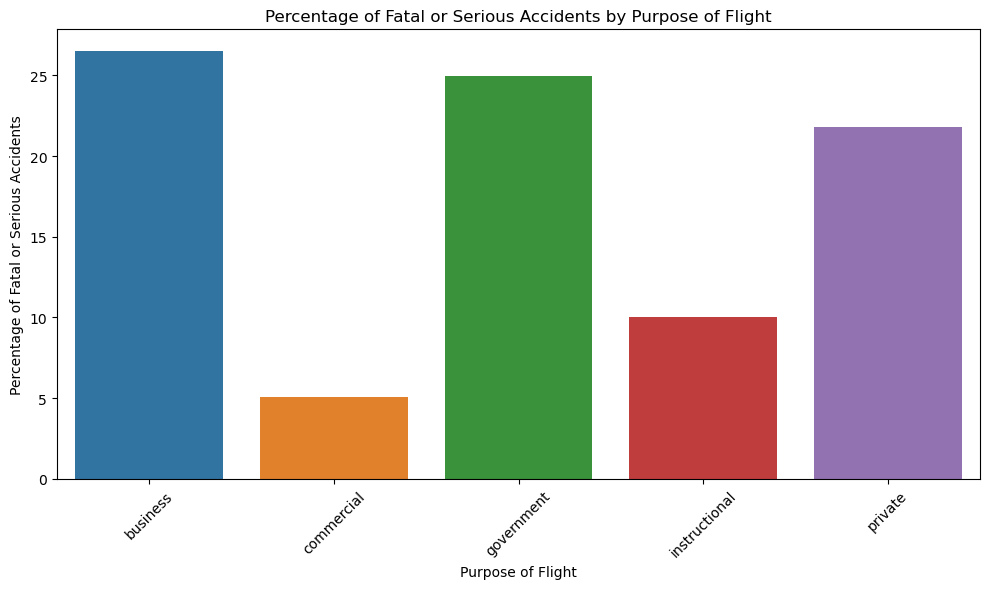

In [755]:
#Filter the specific values in 'purpose_of_flight' that will be graphed
purposes_to_graph = ['private', 'instructional', 'business', 'commercial', 'government']
filtered_data_purp = aviation_data[aviation_data['purpose_of_flight'].isin(purposes_to_graph)]
display(filtered_data_purp['purpose_of_flight'].isna().sum())

#Calculate the percentage of serious injury severity, by grouping the data
#Flatten the dataframe, creating a new column 'percentage'
severity_percentage_purp = filtered_data_purp.groupby('purpose_of_flight').apply(lambda x: (x['severity_category'].value_counts(normalize=True)*100)['Fatal or Serious']).reset_index(name='percentage')

#Plot graph
plt.figure(figsize=(10,6))
sns.barplot(x='purpose_of_flight', y='percentage', data=severity_percentage_purp)
plt.title('Percentage of Fatal or Serious Accidents by Purpose of Flight')
plt.xlabel('Purpose of Flight')
plt.ylabel('Percentage of Fatal or Serious Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interesting. Let's plot the number of severe injuries in comparison to the total number of accidents that occurred per each purpose of flight. To get a better visual.

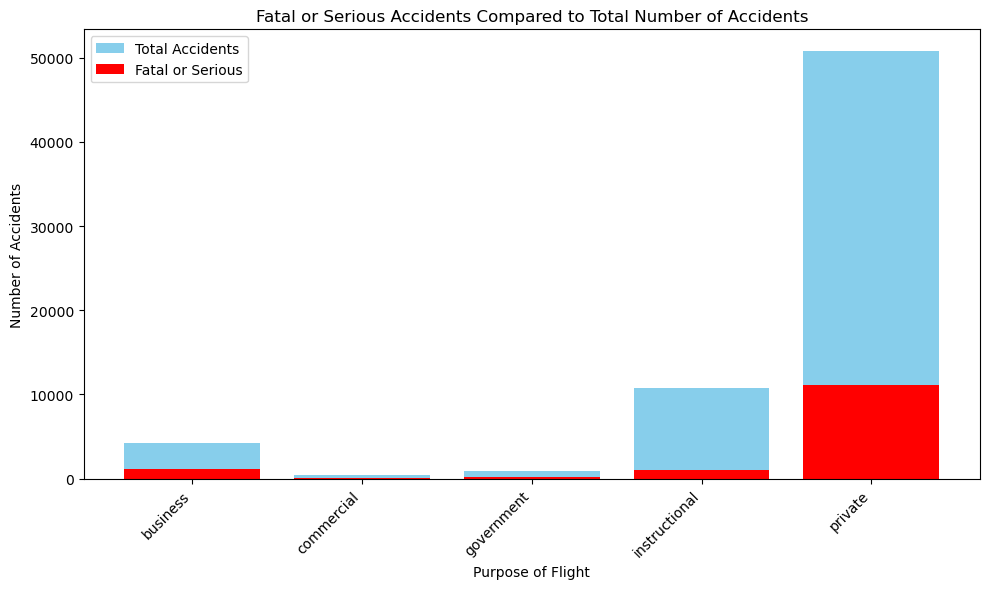

In [756]:
#Total number of accidents per 'purpose_of_flight'
total_accidents_purp = filtered_data_purp.groupby('purpose_of_flight').size().reset_index(name='total_accidents_purp')
#'Fatal or Serious' only from dataframe
fatal_or_serious_purp = filtered_data_purp[filtered_data_purp['severity_category'] == 'Fatal or Serious']

#Grouping by 'purpose_of_flight' to count the number of fatal or serious accidents
fatal_or_serious_counts_purp = fatal_or_serious_purp.groupby('purpose_of_flight').size().reset_index(name='fatal_or_serious_purp')

#Merge the two filtered dataframes on 'purpose_of_flight'
merged_df_purp = pd.merge(total_accidents_purp, fatal_or_serious_counts_purp, on='purpose_of_flight')

# Export the merged data to a CSV file
merged_df_purp.to_csv('tableau_data/purpose_of_flight_accidents.csv', index=False)
#Plot graph
plt.figure(figsize=(10,6))
#Plot the total number of accidents
plt.bar(merged_df_purp['purpose_of_flight'], merged_df_purp['total_accidents_purp'], label='Total Accidents', color='skyblue')
#Plot the 'Fatal or Serious' accidents on top of total accidents
plt.bar(merged_df_purp['purpose_of_flight'], merged_df_purp['fatal_or_serious_purp'], label='Fatal or Serious', color='red')
#Add labels and a title
plt.title('Fatal or Serious Accidents Compared to Total Number of Accidents')
plt.xlabel('Purpose of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Normalized

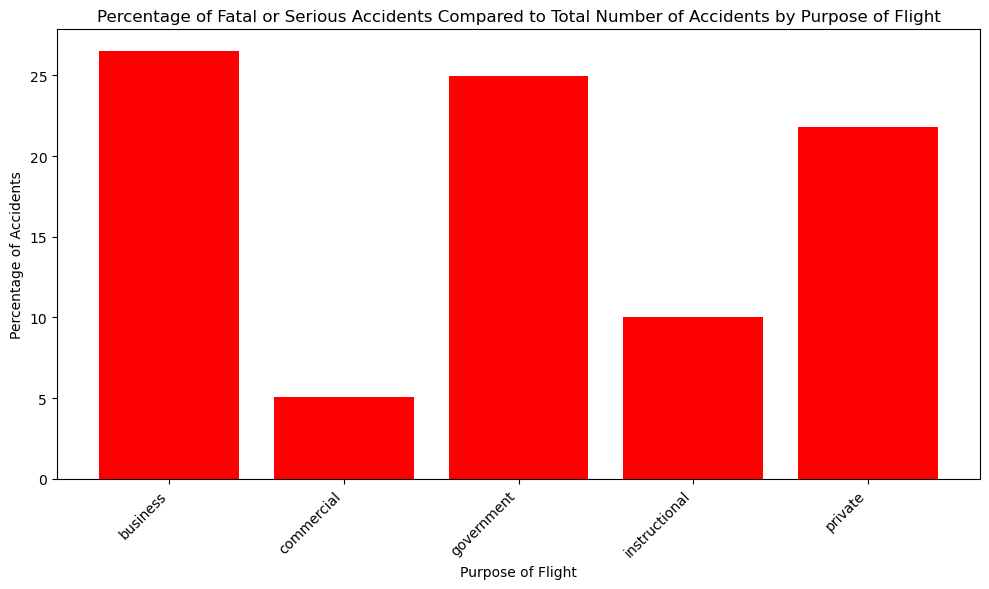

In [757]:
# Total number of accidents per 'purpose_of_flight'
total_accidents_purp = filtered_data_purp.groupby('purpose_of_flight').size().reset_index(name='total_accidents_purp')

# 'Fatal or Serious' only from dataframe
fatal_or_serious_purp = filtered_data_purp[filtered_data_purp['severity_category'] == 'Fatal or Serious']

# Grouping by 'purpose_of_flight' to count the number of fatal or serious accidents
fatal_or_serious_counts_purp = fatal_or_serious_purp.groupby('purpose_of_flight').size().reset_index(name='fatal_or_serious_purp')

# Merge the two filtered dataframes on 'purpose_of_flight'
merged_df_purp = pd.merge(total_accidents_purp, fatal_or_serious_counts_purp, on='purpose_of_flight')

# Calculate the percentage of 'Fatal or Serious' accidents relative to the total number of accidents
merged_df_purp['fatal_or_serious_percentage'] = (merged_df_purp['fatal_or_serious_purp'] / merged_df_purp['total_accidents_purp']) * 100

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot the percentage of 'Fatal or Serious' accidents compared to total accidents
plt.bar(merged_df_purp['purpose_of_flight'], merged_df_purp['fatal_or_serious_percentage'], color='red')

plt.title('Percentage of Fatal or Serious Accidents Compared to Total Number of Accidents by Purpose of Flight')
plt.xlabel('Purpose of Flight')
plt.ylabel('Percentage of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This drastically changes our perception of these numbers. Let's hone in on **commercial** and flights, since they seem to have a drastically lesser number of accidents. We need to zoom in, in order to get a better sense of the "severity ratio".

Government air travel also appears to be low risk, but this is irrelevant for our analysis. The company to which we are pitching is not affiliated with the government, so they will not have the option to engage in this kind of air travel. "Instructional" air travel is irrelevant to our analysis as well. We can filter those out from now on. 

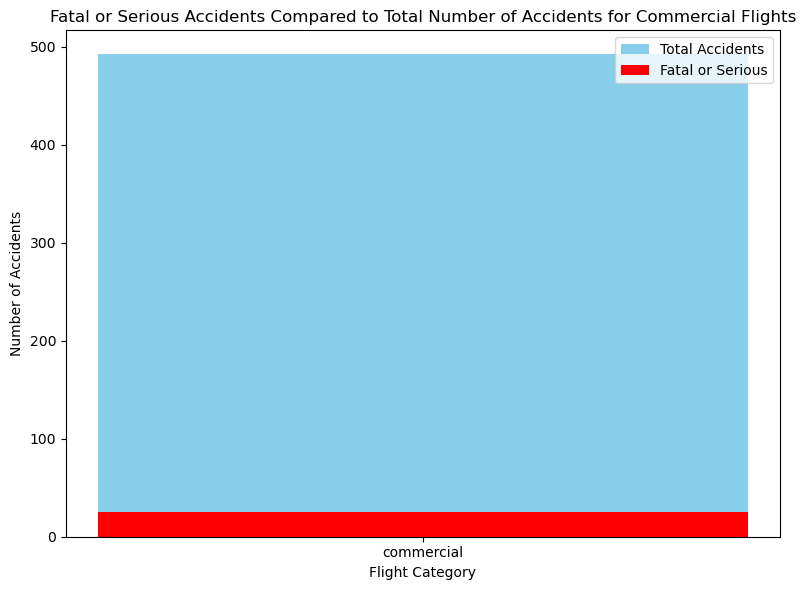

In [758]:
#Plotting the same graph but only for 'commercial' flights
commercial_data_purp = merged_df_purp[merged_df_purp['purpose_of_flight'] == 'commercial']

#Plotting graph
plt.figure(figsize=(8,6))
plt.bar(commercial_data_purp['purpose_of_flight'], commercial_data_purp['total_accidents_purp'], label='Total Accidents', color='skyblue')
plt.bar(commercial_data_purp['purpose_of_flight'], commercial_data_purp['fatal_or_serious_purp'], label='Fatal or Serious', color='red')
plt.title('Fatal or Serious Accidents Compared to Total Number of Accidents for Commercial Flights')
plt.xlabel('Flight Category')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

Clearly, commercial flights are far lower risk: both in terms of total accidents, as well as percentage of accidents that are fatal or serious. 

The highest risk flights seem, by far, to be private. Let's take commercial flights and private flights and examine these further. Accounting for other risk factors such as weather, broad phase of flight, etc. that might be affecting our perception of the numbers. 

Before we continue on, let's quickly analyze this data by **aircraft category**. We've already established that our company is looking to buy airplanes, specifically...but let's examine the numbers briefly.

In [759]:
total_accidents_ac = aviation_data.groupby('aircraft_category').size().reset_index(name='total_accidents_ac')
total_accidents_ac.value_counts()

aircraft_category  total_accidents_ac
airplane           67928                 1
balloon            464                   1
blimp              5                     1
glider             881                   1
gyrocraft          200                   1
helicopter         7236                  1
powered parachute  92                    1
powered-lift       6                     1
rocket             1                     1
ultralight         32                    1
unknown            16                    1
weight-shift       162                   1
dtype: int64

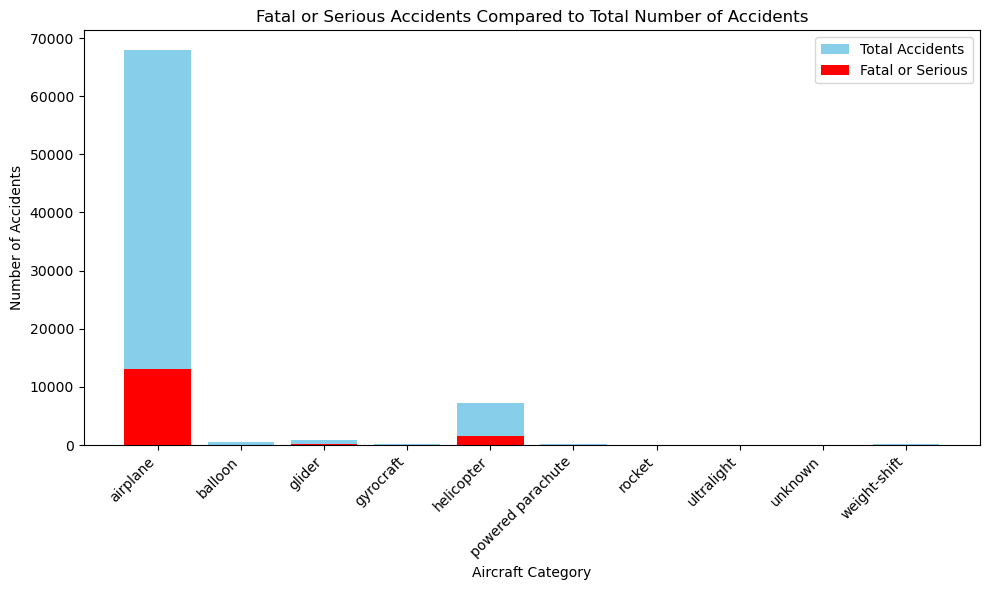

In [760]:
#Total number of accidents per 'aircraft_category'
total_accidents_ac = aviation_data.groupby('aircraft_category').size().reset_index(name='total_accidents_ac')
#'Fatal or Serious' only from dataframe
fatal_or_serious_ac = aviation_data[aviation_data['severity_category'] == 'Fatal or Serious']

#Grouping by 'aircraft_category' to count the number of fatal or serious accidents
fatal_or_serious_counts_ac = fatal_or_serious_ac.groupby('aircraft_category').size().reset_index(name='fatal_or_serious_ac')

#Merge the two filtered dataframes on 'purpose_of_flight'
merged_df_ac = pd.merge(total_accidents_ac, fatal_or_serious_counts_ac, on='aircraft_category')

#Plot graph
plt.figure(figsize=(10,6))
#Plot the total number of accidents
plt.bar(merged_df_ac['aircraft_category'], merged_df_ac['total_accidents_ac'], label='Total Accidents', color='skyblue')
#Plot the 'Fatal or Serious' accidents on top of total accidents
plt.bar(merged_df_ac['aircraft_category'], merged_df_ac['fatal_or_serious_ac'], label='Fatal or Serious', color='red')
#Add labels and a title
plt.title('Fatal or Serious Accidents Compared to Total Number of Accidents')
plt.xlabel('Aircraft Category')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [761]:
# Ensure no division by zero in proportion calculations
merged_df_ac['fatal_to_total_ratio'] = merged_df_ac.apply(
    lambda row: row['fatal_or_serious_ac'] / row['total_accidents_ac'] if row['total_accidents_ac'] > 0 else 0,
    axis=1
)
print(merged_df_ac[['fatal_or_serious_ac', 'total_accidents_ac', 'fatal_to_total_ratio']].head(10))

   fatal_or_serious_ac  total_accidents_ac  fatal_to_total_ratio
0                13147               67928              0.193543
1                   38                 464              0.081897
2                  147                 881              0.166856
3                   49                 200              0.245000
4                 1537                7236              0.212410
5                   16                  92              0.173913
6                    1                   1              1.000000
7                    8                  32              0.250000
8                    7                  16              0.437500
9                   55                 162              0.339506


### Normalize

We have a lot more data on airplanes (as shown in the cell below). To account for this, let's normalize the graph - calculating the proportion of 'fatal or serious' accidents relative to the total number of accidents for each individual aircraft category.

In [762]:
aviation_data['aircraft_category'].value_counts()

airplane             67928
helicopter            7236
glider                 881
balloon                464
gyrocraft              200
weight-shift           162
powered parachute       92
ultralight              32
unknown                 16
powered-lift             6
blimp                    5
rocket                   1
Name: aircraft_category, dtype: int64

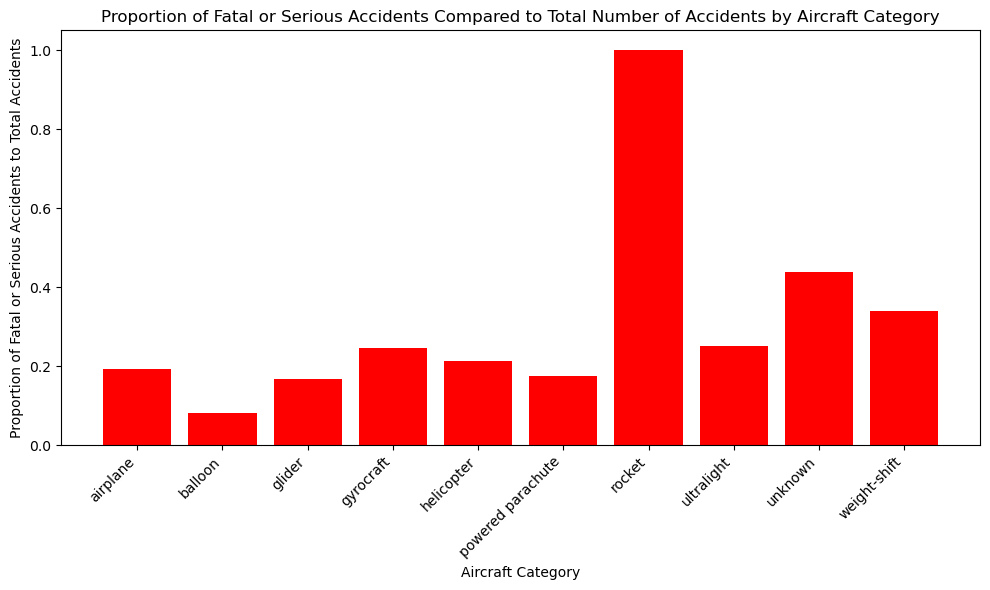

In [763]:
# Calculate the proportion of fatal or serious accidents to total accidents for each aircraft category
#merged_df_ac['fatal_to_total_ratio'] = merged_df_ac['fatal_or_serious_ac'] / merged_df_ac['total_accidents_ac']
# Calculate proportions safely
merged_df_ac['fatal_to_total_ratio'] = merged_df_ac.apply(
    lambda row: row['fatal_or_serious_ac'] / row['total_accidents_ac'] if row['total_accidents_ac'] > 0 else 0,
    axis=1
)

# Plot the proportion of fatal or serious accidents compared to the total number of accidents
plt.figure(figsize=(10, 6))
plt.bar(merged_df_ac['aircraft_category'], merged_df_ac['fatal_to_total_ratio'], color='red')
plt.title('Proportion of Fatal or Serious Accidents Compared to Total Number of Accidents by Aircraft Category')
plt.xlabel('Aircraft Category')
plt.ylabel('Proportion of Fatal or Serious Accidents to Total Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Conclusion: Airplanes

Thankfully, it looks like airplanes are low-risk. Now we can continue our analysis, honing in on the low-risk commercial flights, and comparing those to high-risk private flights.  Balloons, gliders and powered parchutes being so safe tho is interesting!  We also expected helicopters to do worse.  The unknown category could use further exploration as an interest point, but we'll leave it unless it becomes relevant to our EDA.

### Further Exploration: Commercial vs. Private Flights

#### Weather

In [764]:
#Reminding ourselves of unique values in 'weather_condition'
aviation_data['weather_condition'].unique()

array(['vmc', 'imc', 'unk', nan], dtype=object)

Let's look at how many commercial and private flights have 'weather_condition' data available. To make sure we have enough information at our disposal.

In [765]:
#Filter the data for 'commercial' and 'private' flights
commercial_private_flights = aviation_data[(aviation_data['purpose_of_flight'].isin(['commercial', 'private'])) & (aviation_data['aircraft_category'] == 'airplane')]

#Count occurrences of 'imc' and 'vmc' weather_condition values, for each category of flight
commercial_imc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'commercial') &
                                                    (commercial_private_flights['weather_condition'] == 'imc')].shape[0]
commercial_vmc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'commercial') &
                                                   (commercial_private_flights['weather_condition'] == 'vmc')].shape[0]
private_imc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'private') &
                                                (commercial_private_flights['weather_condition'] == 'imc')].shape[0]
private_vmc_count = commercial_private_flights[(commercial_private_flights['purpose_of_flight'] == 'private') &
                                                (commercial_private_flights['weather_condition'] == 'vmc')].shape[0]

print("commercial imc count:", commercial_imc_count)
print("commercial vmc count:", commercial_vmc_count)
print("private imc count:", private_imc_count)
print("private_vmc_count:", private_vmc_count)

commercial imc count: 61
commercial vmc count: 256
private imc count: 3033
private_vmc_count: 36424


These numbers are interesting, because for both private and commercial flights, there is a higher number of accidents documented during 'vmc' weather conditions. *IMC* indicates worse weather conditions, with visibility and cloud cover where the pilots must rely on cockpit instruments...IMC is what we consider "worse" weather, so it's interesting that VMC has a higher number of documented accidents.

This could suggest a **problem with pilot navigation**.

Let's plot these numbers with the 'Fatal or Serious' compared to total accidents ratio we were using before.

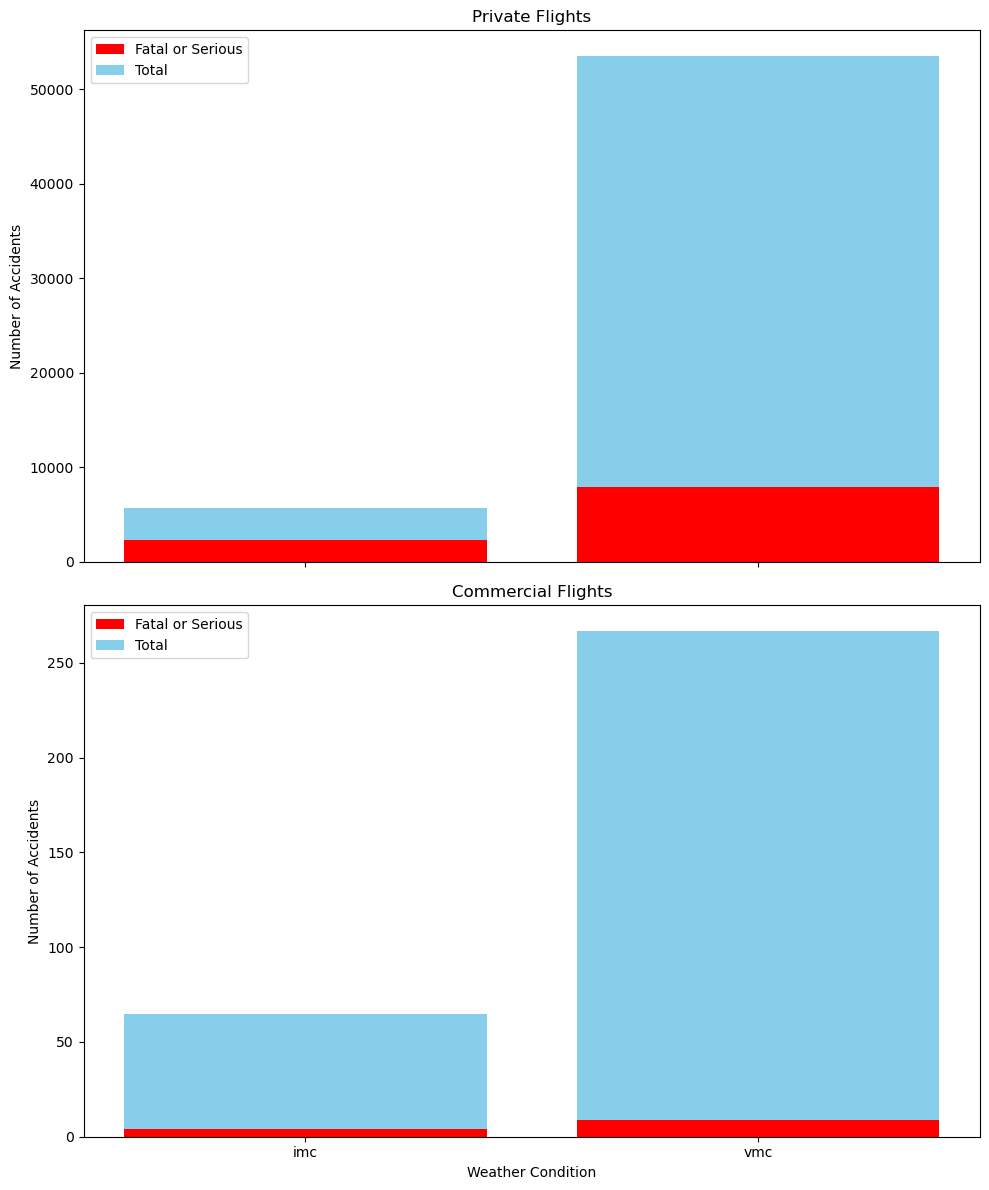

In [766]:
weather_conditions = ['imc', 'vmc']

# Using subplots this time
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

for i, flight_type in enumerate(['private', 'commercial']):
    # Filter data for the current flight type
    flight_data = aviation_data[aviation_data['purpose_of_flight'] == flight_type]
    
    # Initialize lists to store the data for each weather condition
    fatal_or_serious_counts = []
    total_accidents = []

    # Iterate over weather conditions
    for weather_condition in weather_conditions:
        # Filter data for the current weather condition
        weather_data = flight_data[flight_data['weather_condition'] == weather_condition]
        
        # Count the number of fatal or serious accidents and total accidents
        fatal_or_serious_counts.append(weather_data['severity_category'].value_counts().get('Fatal or Serious', 0))
        total_accidents.append(len(weather_data))
    
    # Plot bars for the current flight type
    axs[i].bar(weather_conditions, fatal_or_serious_counts, label='Fatal or Serious', color='red')
    axs[i].bar(weather_conditions, total_accidents, bottom=fatal_or_serious_counts, label='Total', color='skyblue')

    # Labels, title, legend
    axs[i].set_ylabel('Number of Accidents')
    axs[i].set_title(f'{flight_type.capitalize()} Flights')
    axs[i].legend()

# Labels, title for the x-axis
axs[1].set_xlabel('Weather Condition')

# Adjust layout
plt.tight_layout()
plt.show()

## Normalized Version

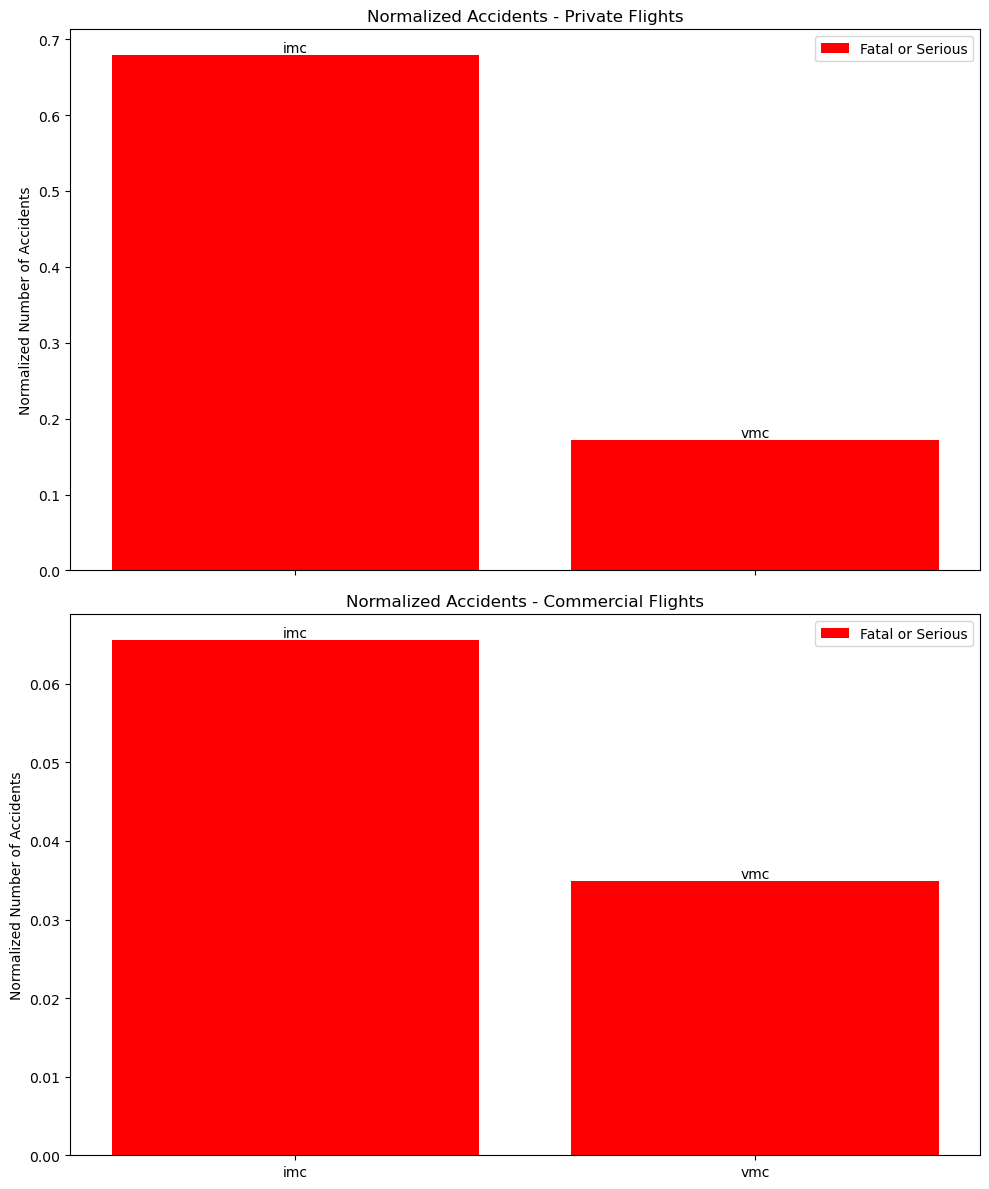

In [767]:
# Get imc and vmc weather conditions
weather_conditions = ['imc', 'vmc']

# Using subplots this time
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

for i, flight_type in enumerate(['private', 'commercial']):
    # Filter data for the current flight type
    flight_data = aviation_data[aviation_data['purpose_of_flight'] == flight_type]
    
    # Initialize lists to store the data for each weather condition
    fatal_or_serious_counts = []
    total_accidents = []

    # Iterate over weather conditions
    for weather_condition in weather_conditions:
        # Filter data for the current weather condition
        weather_data = flight_data[flight_data['weather_condition'] == weather_condition]
        
        # Count the number of fatal or serious accidents and total accidents
        fatal_or_serious_counts.append(weather_data['severity_category'].value_counts().get('Fatal or Serious', 0))
        total_accidents.append(len(weather_data))
    
    # Normalize data
    total_accidents = np.array(total_accidents)
    total_accidents[total_accidents == 0] = 1  # Avoid division by zero
    fatal_or_serious_counts_normalized = np.array(fatal_or_serious_counts) / total_accidents
    
    # Plot bars for the current flight type
    bars = axs[i].bar(weather_conditions, fatal_or_serious_counts_normalized, label='Fatal or Serious', color='red')

    # Labels, title, legend
    axs[i].set_ylabel('Normalized Number of Accidents')
    axs[i].set_title(f'Normalized Accidents - {flight_type.capitalize()} Flights')
    axs[i].legend()

    # Add weather condition labels atop each bar
    for bar, weather_condition in zip(bars, weather_conditions):
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, height, weather_condition, ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

From normalizing the data, it's clear that a far greater proportion of 'fatal or serious' accidents happen during **IMC** weather conditions for both private and commercial flights. 

This implies 'fatal or serious' crashes are **not** necessarily a pilot issue, and instead are likely influenced by other factors such as poor weather, and cockpit instrument malfunction.

#### Broad Phase of Flight

Let's do the same thing examining broad phase of flight, this time looking at only the number of 'fatal or serious' accidents for commercial and privatae flights.

In [768]:
aviation_data['broad_phase_of_flight'].unique()

array(['takeoff', 'landing', 'cruise', 'approach', 'taxi', 'unknown',
       'descent', 'maneuvering', 'climb', 'standing', 'go-around',
       'other', nan], dtype=object)

In [769]:
aviation_data['broad_phase_of_flight'].value_counts()

landing        15423
takeoff        12481
cruise         10260
maneuvering     8138
approach        6537
climb           2030
taxi            1958
descent         1886
go-around       1353
standing         945
unknown          546
other            119
Name: broad_phase_of_flight, dtype: int64

In [770]:
# Filter out rows where 'broad_phase_of_flight' is 'other', 'unknown' or NaN
filtered_pf = aviation_data[~aviation_data['broad_phase_of_flight'].isin(['other', 'unknown']) & aviation_data['broad_phase_of_flight'].notna()]

# Get the filtered 'broad_phase_of_flight' column
phase_flight = filtered_pf['broad_phase_of_flight'].unique()

phase_flight

array(['takeoff', 'landing', 'cruise', 'approach', 'taxi', 'descent',
       'maneuvering', 'climb', 'standing', 'go-around'], dtype=object)

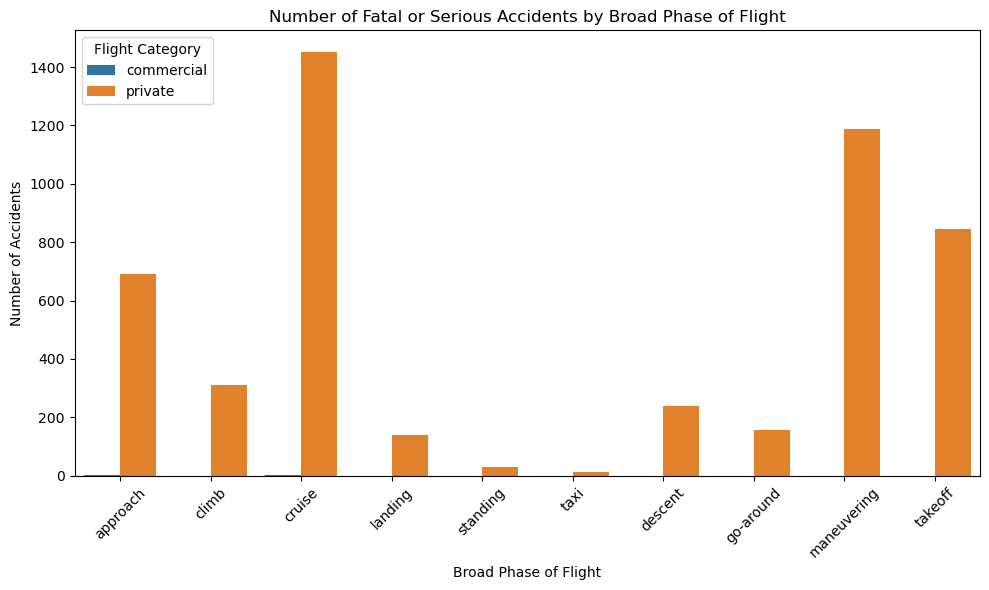

In [771]:
#phase_flight = ['cruise', 'approach', 'climb', 'takeoff', 'landing', 'taxi', 'descent', 'maneuvering', 'standing', 'go-around']

filtered_data_pf = commercial_private_flights[commercial_private_flights['broad_phase_of_flight'].isin(phase_flight)]
fatal_or_serious_counts_pf = filtered_data_pf.groupby(['purpose_of_flight', 'broad_phase_of_flight'])['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(x='broad_phase_of_flight', y='count', hue='purpose_of_flight', data=fatal_or_serious_counts_pf)
plt.title('Number of Fatal or Serious Accidents by Broad Phase of Flight')
plt.xlabel('Broad Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Flight Category')
plt.tight_layout()
plt.show()

Private flights have a drastically higher amount of accidents. Which means it's near impossible to visualize accidents on commercial flights in comparison. Let's do this same graph, but with commercial flights only.

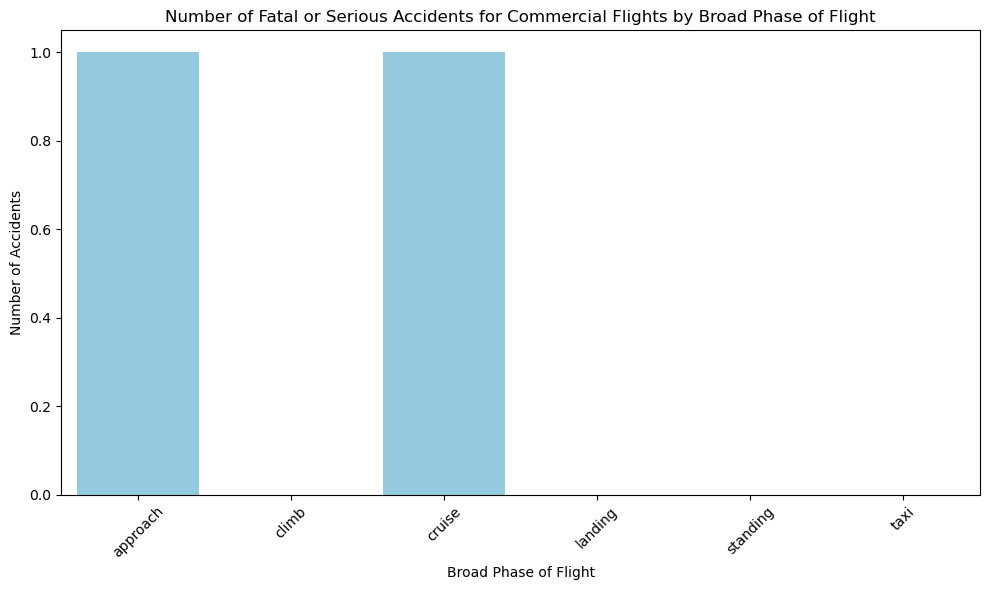

In [772]:
#Filtering data for only commercial flights
commercial_flights = aviation_data[(aviation_data['purpose_of_flight'] == 'commercial') & (aviation_data['aircraft_category'] == 'airplane')]
filtered_data_pf = commercial_flights[commercial_flights['broad_phase_of_flight'].isin(phase_flight)]
fatal_or_serious_counts_pf = filtered_data_pf.groupby('broad_phase_of_flight')['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(x='broad_phase_of_flight', y='count', data=fatal_or_serious_counts_pf, color='skyblue')
plt.title('Number of Fatal or Serious Accidents for Commercial Flights by Broad Phase of Flight')
plt.xlabel('Broad Phase of Flight')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Normalized Version

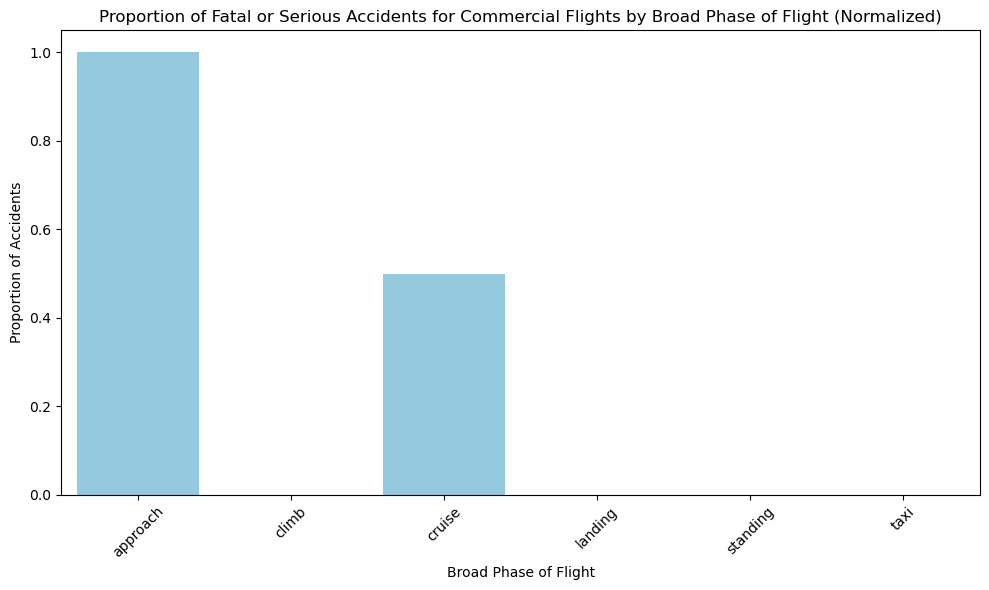

In [773]:
total_accidents_pf_n = filtered_data_pf.groupby('broad_phase_of_flight').size().reset_index(name='total_accidents')

# Merge with fatal_or_serious_counts_pf to calculate proportion
fatal_or_serious_counts_pf_n = filtered_data_pf.groupby('broad_phase_of_flight')['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')
fatal_or_serious_counts_pf_n = pd.merge(fatal_or_serious_counts_pf_n, total_accidents_pf_n, on='broad_phase_of_flight')

# Calculate proportion of fatal or serious accidents relative to total accidents
fatal_or_serious_counts_pf_n['proportion'] = fatal_or_serious_counts_pf_n['count'] / fatal_or_serious_counts_pf_n['total_accidents']

# Plot the normalized graph
plt.figure(figsize=(10,6))
sns.barplot(x='broad_phase_of_flight', y='proportion', data=fatal_or_serious_counts_pf_n, color='skyblue')
plt.title('Proportion of Fatal or Serious Accidents for Commercial Flights by Broad Phase of Flight (Normalized)')
plt.xlabel('Broad Phase of Flight')
plt.ylabel('Proportion of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [774]:
commercial_flights['broad_phase_of_flight'].value_counts()

taxi        11
standing     4
climb        3
cruise       2
landing      2
approach     1
Name: broad_phase_of_flight, dtype: int64

#### Outside research tells us that **landing** is actually the most accident-prone phase of flight. Clearly, there's not enough data to give us accurate depictions of these graphs. We'll keep the graphs in the notebook, in case there's an opportunity to fill in more data. Then our code will update, and these graphs above will have more information.

### Conclusion: Commercial

Commercial flights are by far safer than private flights.

# Features of Aircraft: Number of Engines

Let's examine the features an aircraft needs to be low-risk. Let's graph the number 'fatal or serious' injuries for commercial and private flights based on number of engines.

In [775]:
commercial_private_flights['number_of_engines'].value_counts()

1    37399
2     3800
4       28
3       13
Name: number_of_engines, dtype: Int64

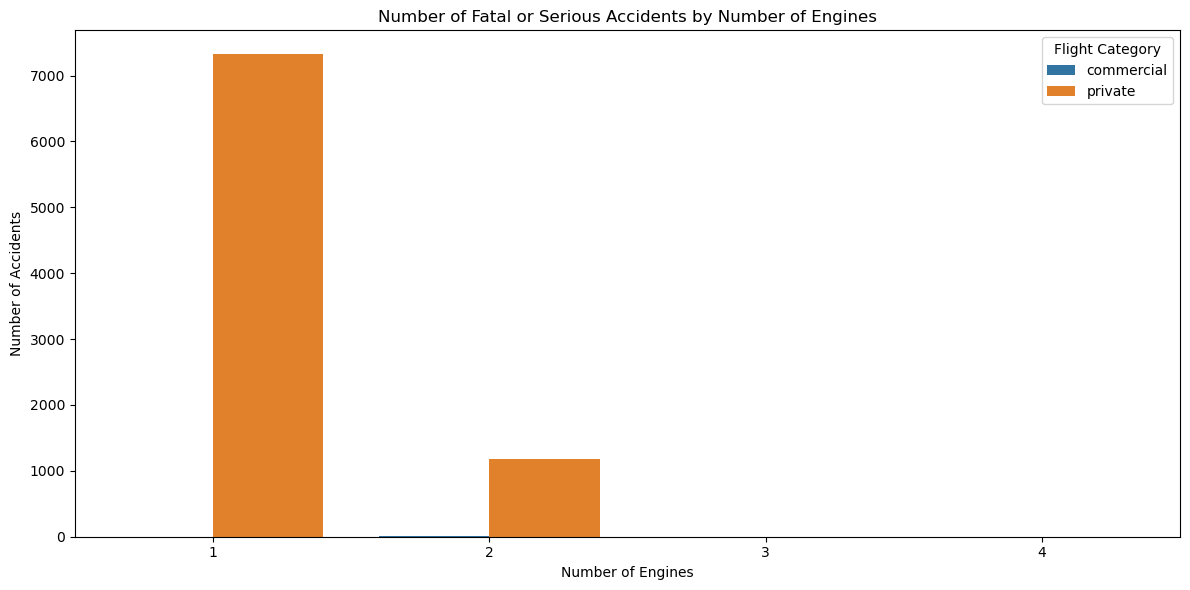

In [776]:
fatal_or_serious_counts = commercial_private_flights.groupby(['number_of_engines', 'purpose_of_flight'])['severity_category'].apply(lambda x: (x == 'Fatal or Serious').sum()).reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(x='number_of_engines', y='count', hue='purpose_of_flight', data=fatal_or_serious_counts)
plt.title('Number of Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend(title='Flight Category')
plt.tight_layout()
plt.show()

Let's adjust our scale and have two separate graphs, so we can look at our commercial flight numbers better.

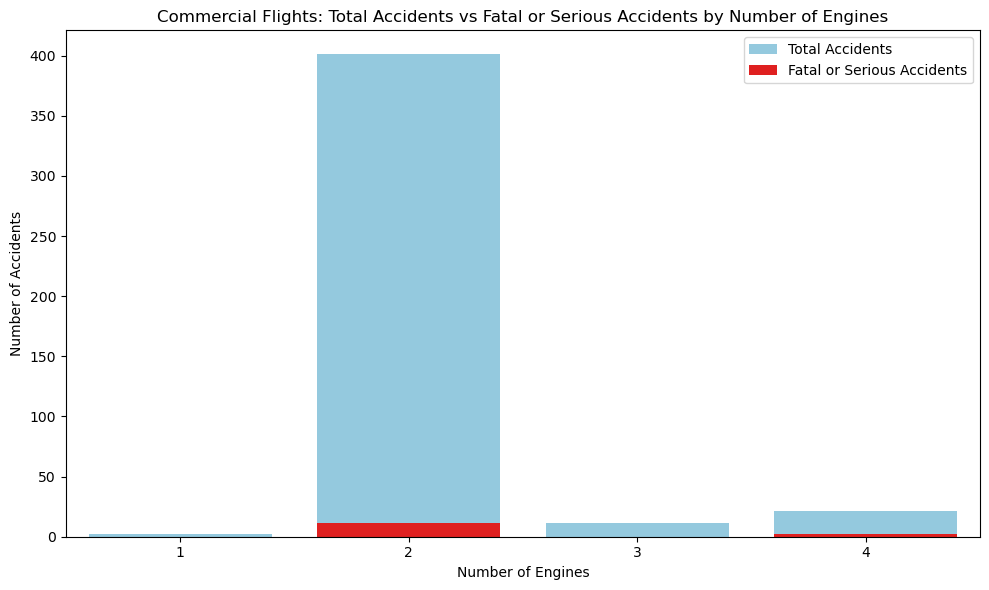

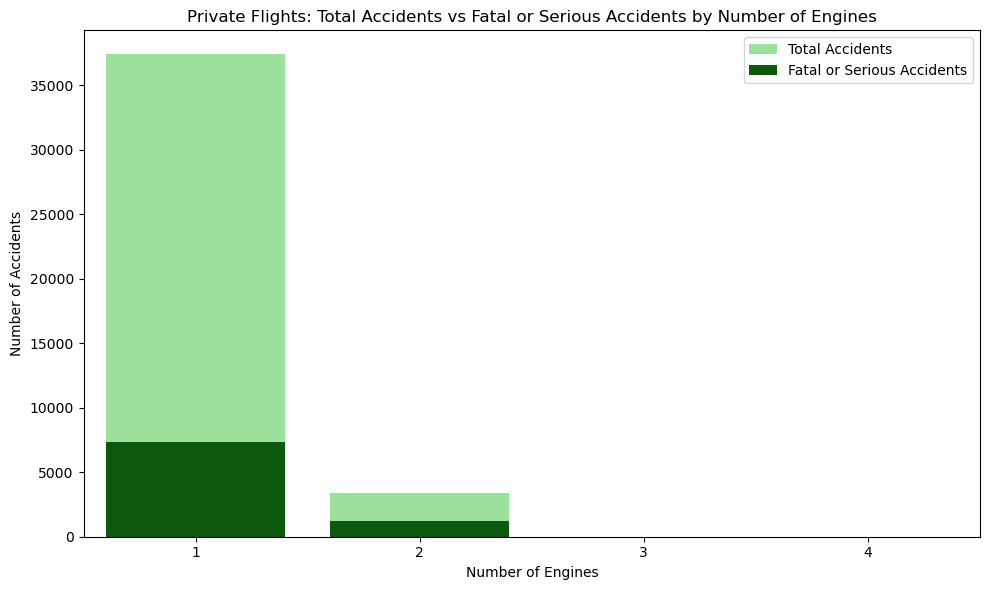

In [777]:
# Filter the data for commercial flights
commercial_flights = aviation_data[(aviation_data['purpose_of_flight'] == 'commercial') & (aviation_data['aircraft_category'] == 'airplane')]

# Group the filtered data by 'number_of_engines' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_commercial = commercial_flights.groupby('number_of_engines').size().reset_index(name='total_accidents')
fatal_or_serious_commercial = commercial_flights[commercial_flights['severity_category'] == 'Fatal or Serious'].groupby('number_of_engines').size().reset_index(name='fatal_or_serious')

# Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for commercial flights
merged_data_commercial = pd.merge(total_accidents_commercial, fatal_or_serious_commercial, on='number_of_engines', how='outer')

# Plot the bar graph for commercial flights
plt.figure(figsize=(10, 6))
sns.barplot(x='number_of_engines', y='total_accidents', data=merged_data_commercial, color='skyblue', label='Total Accidents')
sns.barplot(x='number_of_engines', y='fatal_or_serious', data=merged_data_commercial, color='red', label='Fatal or Serious Accidents')

plt.title('Commercial Flights: Total Accidents vs Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

# Filter the data for private flights
private_flights = aviation_data[(aviation_data['purpose_of_flight'] == 'private') & (aviation_data['aircraft_category'] == 'airplane')]

# Group the filtered data by 'number_of_engines' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_private = private_flights.groupby('number_of_engines').size().reset_index(name='total_accidents')
fatal_or_serious_private = private_flights[private_flights['severity_category'] == 'Fatal or Serious'].groupby('number_of_engines').size().reset_index(name='fatal_or_serious')

# Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for private flights
merged_data_private = pd.merge(total_accidents_private, fatal_or_serious_private, on='number_of_engines', how='outer')

# Plot the bar graph for private flights
plt.figure(figsize=(10, 6))
sns.barplot(x='number_of_engines', y='total_accidents', data=merged_data_private, color='lightgreen', label='Total Accidents')
sns.barplot(x='number_of_engines', y='fatal_or_serious', data=merged_data_private, color='darkgreen', label='Fatal or Serious Accidents')

plt.title('Private Flights: Total Accidents vs Fatal or Serious Accidents by Number of Engines')
plt.xlabel('Number of Engines')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

Let's check how much data our graph is drawing from.

In [778]:
commercial_flights['number_of_engines'].value_counts()

2    401
4     21
3     11
1      2
Name: number_of_engines, dtype: Int64

In [779]:
private_flights['number_of_engines'].value_counts()

1    37397
2     3399
4        7
3        2
Name: number_of_engines, dtype: Int64

## Conclusion: 2 or More Engines

If we compare the two graphs above, knowing that **commercial flights are safer** than private flights...then we can conclude that the number of engines found most on commercial airplanes is the lowest-risk.

From this we can deduce that having **2 engines or more** is the low-risk option when purchasing an aircraft.

# Engine Type

Let's do the same thing, examining engine type

In [780]:
commercial_flights['engine_type'].value_counts()

turbo fan          336
turbo prop          38
turbo jet           36
reciprocating        4
turbo shaft          1
geared turbofan      1
Name: engine_type, dtype: int64

In [781]:
private_flights['engine_type'].value_counts()

reciprocating    39915
turbo prop         520
turbo fan          163
turbo jet           46
turbo shaft          2
electric             1
Name: engine_type, dtype: int64

By now, we can infer that whatever aircraft feature belongs primarily to commercial aircraft is going to be safest, and that the opposite will be true for private aircraft. So based on our value counts, we can infer that 'turbo fan' is the lowest-risk engine type, and 'reciprocating' is the highest-risk.  

Let's plot the same graphs for private flights, looking at the 'Fatal or Serious' to total accidents ratio.

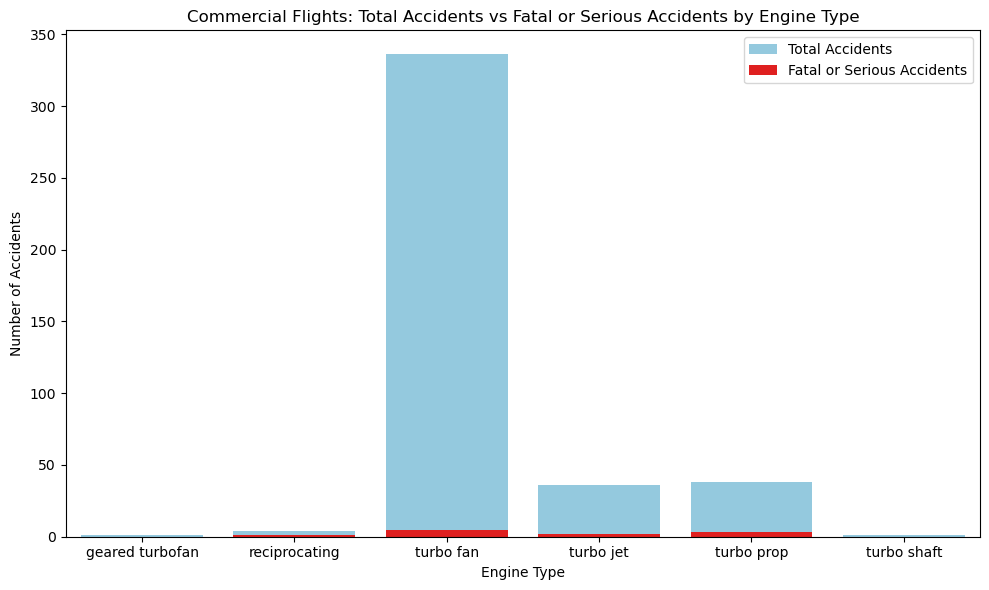

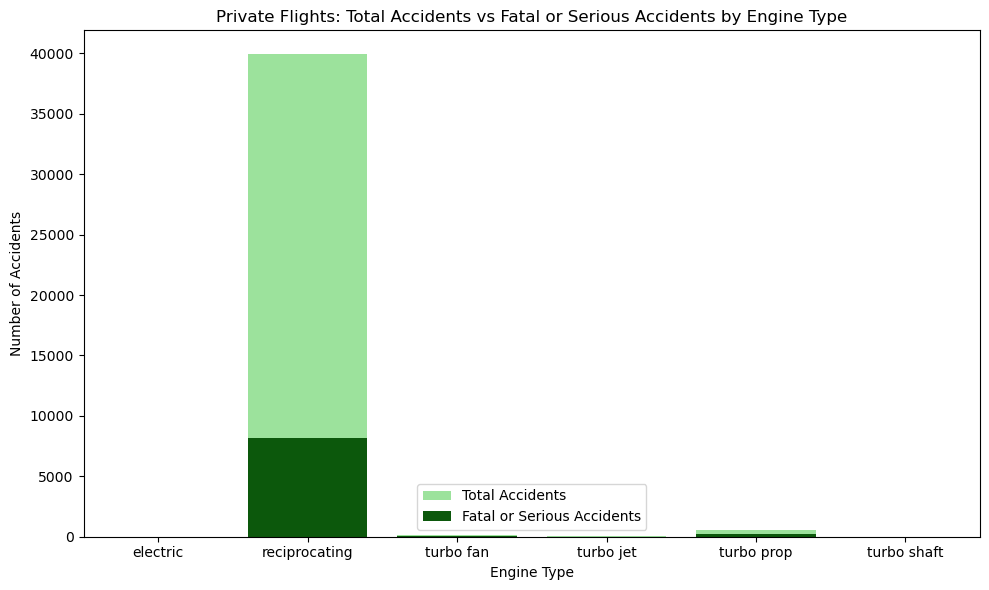

In [782]:
# Filter the data for commercial flights
commercial_flights = aviation_data[(aviation_data['purpose_of_flight'] == 'commercial') & (aviation_data['aircraft_category'] == 'airplane')]

# Group the filtered data by 'engine_type' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_commercial = commercial_flights.groupby('engine_type').size().reset_index(name='total_accidents')
fatal_or_serious_commercial = commercial_flights[commercial_flights['severity_category'] == 'Fatal or Serious'].groupby('engine_type').size().reset_index(name='fatal_or_serious')

# Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for commercial flights
merged_data_commercial = pd.merge(total_accidents_commercial, fatal_or_serious_commercial, on='engine_type', how='outer')

# Fill NaN values with 0 (in case there are engine types with no 'Fatal or Serious' accidents)
merged_data_commercial['fatal_or_serious'].fillna(0, inplace=True)
# Export the merged data to a CSV file
merged_data_commercial.to_csv('tableau_data/commercial_flights_total_accidents_vs_fatal_or_serious_accidents_by_engine_type.csv', index=False)

# Plot the bar graph for commercial flights
plt.figure(figsize=(10, 6))
sns.barplot(x='engine_type', y='total_accidents', data=merged_data_commercial, color='skyblue', label='Total Accidents')
sns.barplot(x='engine_type', y='fatal_or_serious', data=merged_data_commercial, color='red', label='Fatal or Serious Accidents')

plt.title('Commercial Flights: Total Accidents vs Fatal or Serious Accidents by Engine Type')
plt.xlabel('Engine Type')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

# Filter the data for private flights
private_flights = aviation_data[(aviation_data['purpose_of_flight'] == 'private') & (aviation_data['aircraft_category'] == 'airplane')]

# Group the filtered data by 'engine_type' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_private = private_flights.groupby('engine_type').size().reset_index(name='total_accidents')
fatal_or_serious_private = private_flights[private_flights['severity_category'] == 'Fatal or Serious'].groupby('engine_type').size().reset_index(name='fatal_or_serious')

# Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for private flights
merged_data_private = pd.merge(total_accidents_private, fatal_or_serious_private, on='engine_type', how='outer')

# Plot the bar graph for private flights
plt.figure(figsize=(10, 6))
sns.barplot(x='engine_type', y='total_accidents', data=merged_data_private, color='lightgreen', label='Total Accidents')
sns.barplot(x='engine_type', y='fatal_or_serious', data=merged_data_private, color='darkgreen', label='Fatal or Serious Accidents')

# Fill NaN values with 0 (in case there are engine types with no 'Fatal or Serious' accidents)
merged_data_private['fatal_or_serious'].fillna(0, inplace=True)

# Export the merged data to a CSV file
merged_data_private.to_csv('tableau_data/private_flights_total_accidents_vs_fatal_or_serious_accidents_by_engine_type.csv', index=False)

plt.title('Private Flights: Total Accidents vs Fatal or Serious Accidents by Engine Type')
plt.xlabel('Engine Type')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

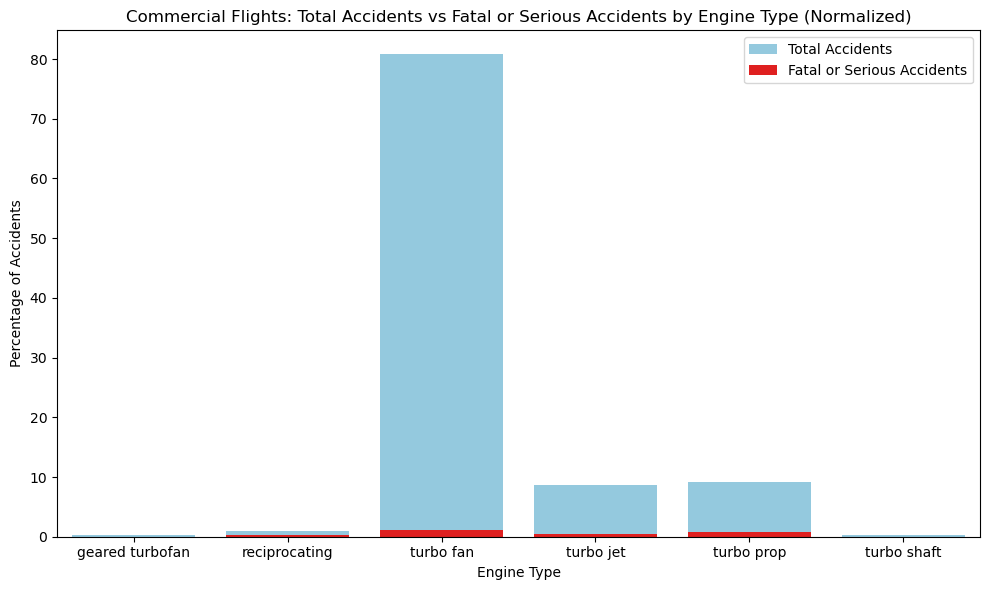

In [783]:
#Filter the data for commercial flights
commercial_flights = aviation_data[(aviation_data['purpose_of_flight'] == 'commercial') & (aviation_data['aircraft_category'] == 'airplane')]

#Group the filtered data by 'engine_type' and calculate the total number of accidents and 'Fatal or Serious' accidents
total_accidents_commercial = commercial_flights.groupby('engine_type').size().reset_index(name='total_accidents')
fatal_or_serious_commercial = commercial_flights[commercial_flights['severity_category'] == 'Fatal or Serious'].groupby('engine_type').size().reset_index(name='fatal_or_serious')

#Merge the dataframes to have the 'total_accidents' and 'fatal_or_serious' columns for commercial flights
merged_data_commercial = pd.merge(total_accidents_commercial, fatal_or_serious_commercial, on='engine_type', how='outer')

#Calculate percentages
merged_data_commercial['total_accidents_percentage'] = (merged_data_commercial['total_accidents'] / merged_data_commercial['total_accidents'].sum()) * 100
merged_data_commercial['fatal_or_serious_percentage'] = (merged_data_commercial['fatal_or_serious'] / merged_data_commercial['total_accidents'].sum()) * 100

#Plot the bar graph for commercial flights with normalized values
plt.figure(figsize=(10, 6))
sns.barplot(x='engine_type', y='total_accidents_percentage', data=merged_data_commercial, color='skyblue', label='Total Accidents')
sns.barplot(x='engine_type', y='fatal_or_serious_percentage', data=merged_data_commercial, color='red', label='Fatal or Serious Accidents')

plt.title('Commercial Flights: Total Accidents vs Fatal or Serious Accidents by Engine Type (Normalized)')
plt.xlabel('Engine Type')
plt.ylabel('Percentage of Accidents')
plt.legend()
plt.tight_layout()
plt.show()


In [784]:
aviation_data.keys()

Index(['event_id', 'investigation_type', 'accident_number', 'event_date',
       'location', 'country', 'airport_code', 'airport_name',
       'aircraft_damage', 'aircraft_category', 'registration_number', 'make',
       'model', 'amateur_built', 'number_of_engines', 'engine_type',
       'far_description', 'schedule', 'purpose_of_flight', 'air_carrier',
       'total_fatal_injuries', 'total_serious_injuries',
       'total_minor_injuries', 'total_uninjured', 'weather_condition',
       'broad_phase_of_flight', 'report_status', 'injury_severity_type',
       'injury_severity_count', 'state', 'year', 'make_model',
       'total_injuries', 'percentage_injured', 'fatal_to_non_ratio',
       'severity_category'],
      dtype='object')

Let's examine whether engines have gone under modifications, or change in 'type' preferences over time. 

Let's extract the 'year' from our 'event_date' column, making a new column in our dataframe.

<Figure size 2000x800 with 0 Axes>

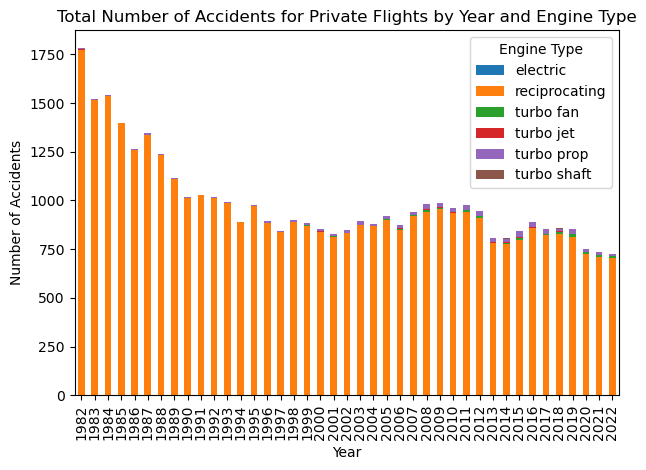

<Figure size 2000x800 with 0 Axes>

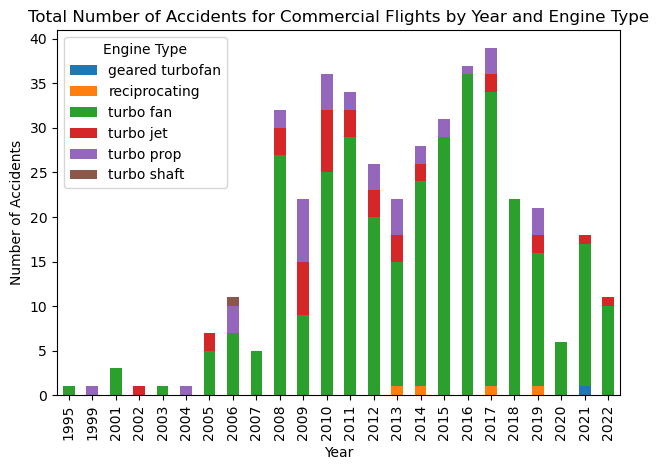

In [785]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
private_flights = private_flights.copy()

# Extract the year from 'event_date' and create a new 'year' column
private_flights['event_date'] = pd.to_datetime(private_flights['event_date'])
private_flights['year'] = private_flights['event_date'].dt.year

# Group the data by 'year' and 'engine_type' and calculate the total number of accidents
accidents_by_year_engine = private_flights.groupby(['year', 'engine_type']).size().reset_index(name='total_accidents')

# Reshape the data to have 'year' as index, 'engine_type' as columns, and 'total_accidents' as values
accidents_by_year_engine_pivot = accidents_by_year_engine.pivot(index='year', columns='engine_type', values='total_accidents').fillna(0)

# Plot the stacked bar graph
plt.figure(figsize=(20, 8))
accidents_by_year_engine_pivot.plot(kind='bar', stacked=True)
plt.title('Total Number of Accidents for Private Flights by Year and Engine Type')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Engine Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
commercial_flights = commercial_flights.copy()

# Extract the year from 'event_date' and create a new 'year' column
commercial_flights['event_date'] = pd.to_datetime(commercial_flights['event_date'])
commercial_flights['year'] = commercial_flights['event_date'].dt.year

# Group the data by 'year' and 'engine_type' and calculate the total number of accidents
accidents_by_year_engine_commercial = commercial_flights.groupby(['year', 'engine_type']).size().reset_index(name='total_accidents')

# Reshape the data to have 'year' as index, 'engine_type' as columns, and 'total_accidents' as values
accidents_by_year_engine_pivot_commercial = accidents_by_year_engine_commercial.pivot(index='year', columns='engine_type', values='total_accidents').fillna(0)

# Plot the stacked bar graph with a larger size
plt.figure(figsize=(20, 8))  # Adjust the width and height as needed
accidents_by_year_engine_pivot_commercial.plot(kind='bar', stacked=True)
plt.title('Total Number of Accidents for Commercial Flights by Year and Engine Type')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Engine Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Normalized

<Figure size 1500x800 with 0 Axes>

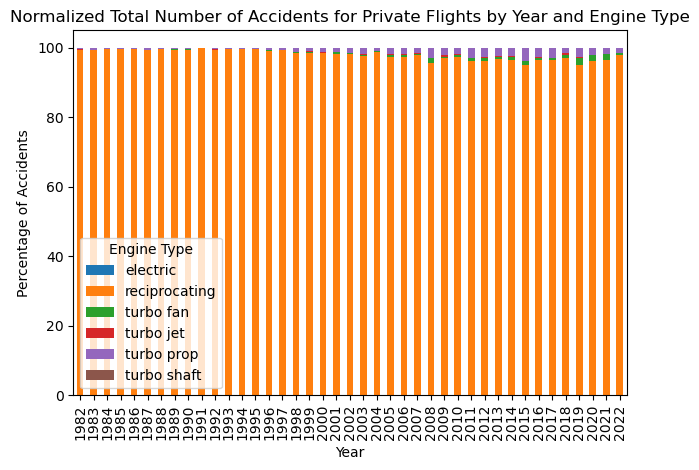

<Figure size 1500x800 with 0 Axes>

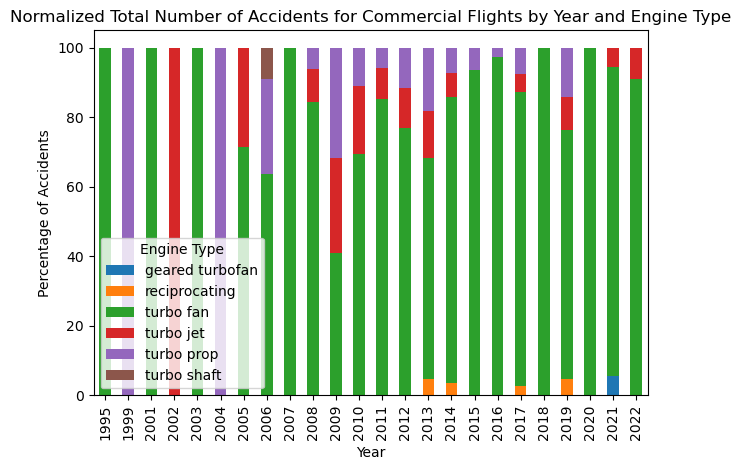

In [786]:
# Define a function to normalize the data
def normalize_data(df):
    # Sum of accidents for each year
    year_totals = df.sum(axis=1)
    # Divide each value by the corresponding year total and multiply by 100 to get percentages
    return df.div(year_totals, axis=0) * 100

# Normalize the data for private flights
accidents_by_year_engine_pivot_normalized = normalize_data(accidents_by_year_engine_pivot)

# Plot the stacked bar graph
plt.figure(figsize=(15, 8))
accidents_by_year_engine_pivot_normalized.plot(kind='bar', stacked=True)
plt.title('Normalized Total Number of Accidents for Private Flights by Year and Engine Type')
plt.xlabel('Year')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Engine Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Normalize the data for commercial flights
accidents_by_year_engine_pivot_commercial_normalized = normalize_data(accidents_by_year_engine_pivot_commercial)

# Plot the stacked bar graph with a larger size
plt.figure(figsize=(15, 8))
accidents_by_year_engine_pivot_commercial_normalized.plot(kind='bar', stacked=True)
plt.title('Normalized Total Number of Accidents for Commercial Flights by Year and Engine Type')
plt.xlabel('Year')
plt.ylabel('Percentage of Accidents')
plt.legend(title='Engine Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Turbo Fan

It looks like turbo-fan is the most widely used engine among commercial flights in modern day. Which means it's likely the lowest-risk.

Let's look at the number of 'fatal or serious' accidents for commercial flights, organized by year. This way we can see if there was a higher count of 'fatal or serious' accidents prior to the increase of turbo-fans in our commercial flights data (which spikes around 2008).

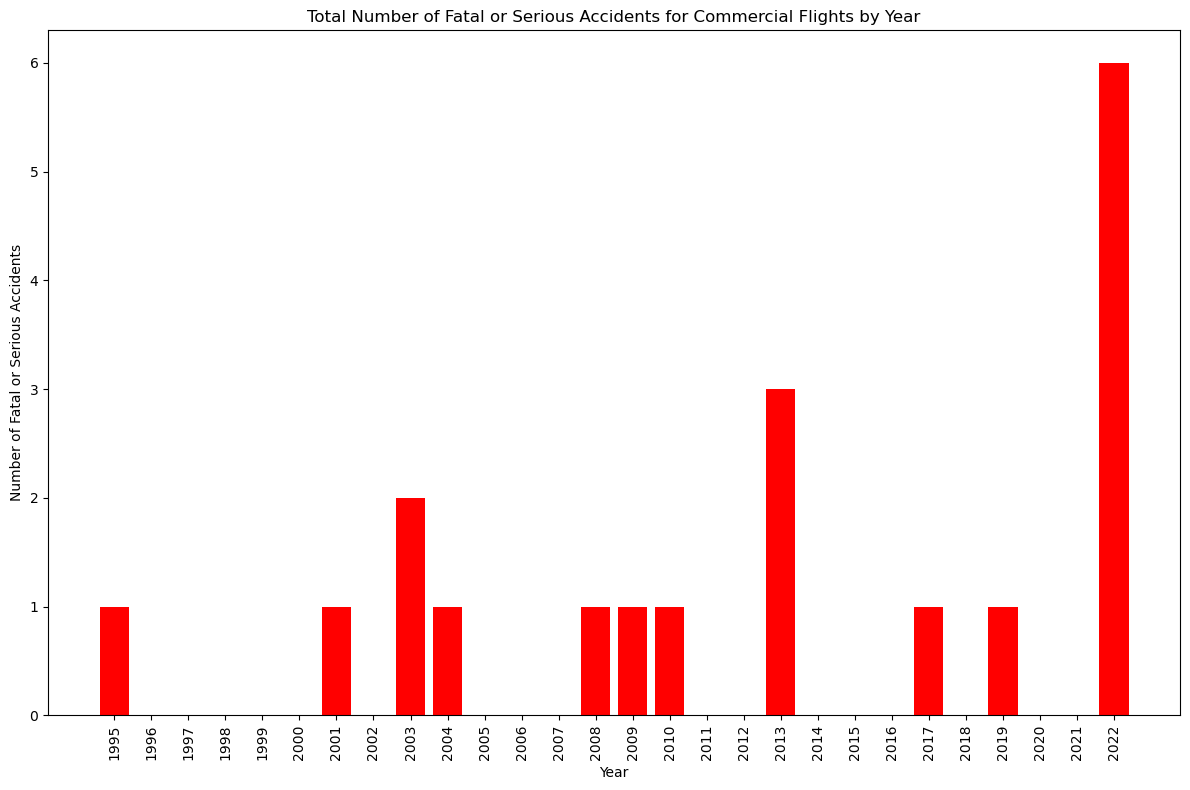

In [787]:
# Filter commercial flights and 'fatal or serious' accidents
commercial_fatal_serious = commercial_flights[commercial_flights['severity_category'] == 'Fatal or Serious']

# Group the data by 'year' and calculate the total number of 'fatal or serious' accidents
fatal_serious_by_year_commercial = commercial_fatal_serious.groupby('year').size().reset_index(name='total_fatal_serious')

#display(fatal_serious_by_year_commercial)

# Plot the total number of 'fatal or serious' accidents for commercial flights by year
plt.figure(figsize=(12, 8))
plt.bar(fatal_serious_by_year_commercial['year'], fatal_serious_by_year_commercial['total_fatal_serious'], color='red')
plt.title('Total Number of Fatal or Serious Accidents for Commercial Flights by Year')
plt.xlabel('Year')
plt.ylabel('Number of Fatal or Serious Accidents')
# Explicitly set the x-ticks
plt.xticks(range(min(fatal_serious_by_year_commercial['year']),max(fatal_serious_by_year_commercial['year'])+1), rotation=90)
plt.tight_layout()
plt.show()


There *does* seem to be an increased levels of 'fatal or serious' commercial flights accidents prior to 2008. Let's plot these accidents in comparison to the number of total accidents to further explore.

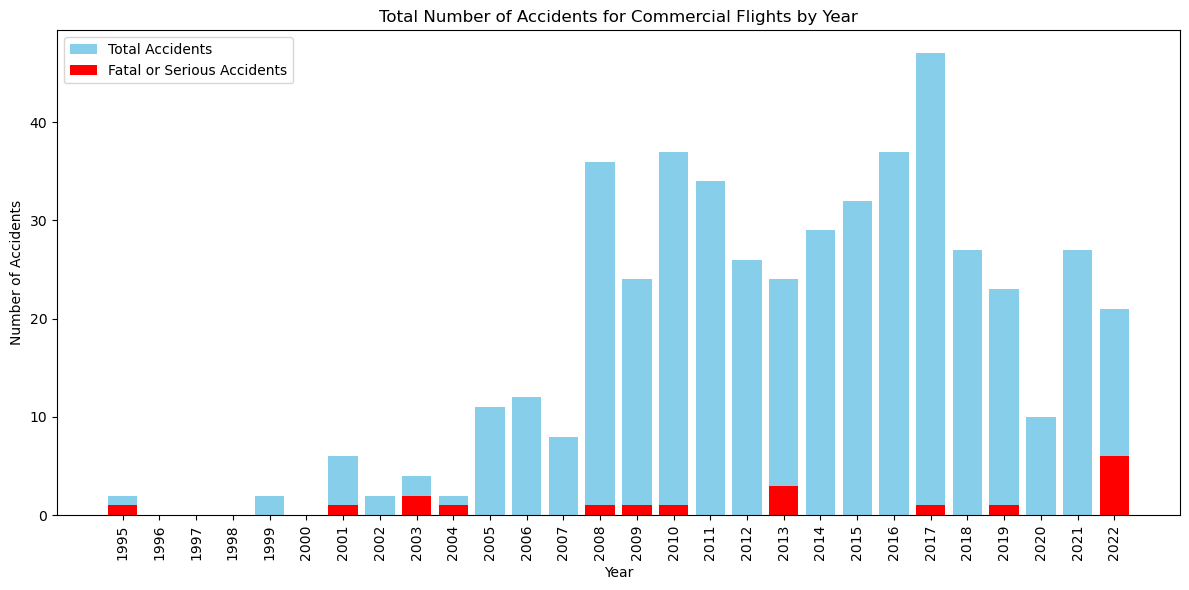

In [788]:
# Group the data by 'year' and calculate the total number of accidents and 'Fatal or Serious' accidents
accidents_by_year_commercial = commercial_flights.groupby('year').size().reset_index(name='total_accidents')
fatal_serious_by_year_commercial = commercial_fatal_serious.groupby('year').size().reset_index(name='total_fatal_serious')

# Merge the total accidents and 'Fatal or Serious' accidents dataframes on 'year'
merged_data_commercial = pd.merge(accidents_by_year_commercial, fatal_serious_by_year_commercial, on='year', how='outer')

# Plot the stacked bar graph
plt.figure(figsize=(12, 6))
plt.bar(merged_data_commercial['year'], merged_data_commercial['total_accidents'], color='skyblue', label='Total Accidents')
plt.bar(merged_data_commercial['year'], merged_data_commercial['total_fatal_serious'], color='red', label='Fatal or Serious Accidents')
plt.title('Total Number of Accidents for Commercial Flights by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
rng = range(min(merged_data_commercial['year']),max(merged_data_commercial['year'])+1)
plt.xticks(rng,rotation=90)
plt.tight_layout()
plt.show()

It looks like this data might be **skewed** because of a lack of data provided for commercial flights prior to 2010. Let's check.

In [789]:
commercial_flights['year'].value_counts(ascending=True)

1995     2
1999     2
2002     2
2004     2
2003     4
2001     6
2007     8
2020    10
2005    11
2006    12
2022    21
2019    23
2013    24
2009    24
2012    26
2021    27
2018    27
2014    29
2015    32
2011    34
2008    36
2016    37
2010    37
2017    47
Name: year, dtype: int64

This confirms our theory for the reason behind our skew. Which means we can't draw any rational conclusions from the last two graphs, but we'll leave them in the notebook in case an opportunity arises to fill in more missing commercial flight data prior to the mid-2000's.

Let's check these value counts for private flights as well.

In [790]:
private_flights['year'].value_counts(ascending=True)

2020     776
2013     810
2014     811
2001     828
2022     832
2021     839
2015     844
1997     845
2002     852
2000     854
2017     860
2018     861
2019     861
2006     873
2004     879
1999     885
2016     890
1994     891
1996     892
2003     893
1998     901
2005     922
2007     942
2012     949
2010     967
1995     975
2011     982
2008     989
1993     990
2009     991
1990    1019
1992    1020
1991    1030
1989    1117
1988    1237
1986    1264
1987    1345
1985    1400
1983    1523
1984    1539
1982    1784
Name: year, dtype: int64

We have a lot more information on private flights, which is not necessarily evidence of inaccuracy. Given that private flights are higher-risk, it makes perfect sense that there would be more instances of (and therefore data on) accidents for these flights.

To better understand our data, let's see if certain engine_types have a set number of engines. Let's do this for reciprocating, turbo fan, turbo jet, turbo prop, and turbo shaft engines - since our initial bar graphs showed us these are the engine types relevant to commercial and private flights.

In [791]:
aviation_data['engine_type'].value_counts()

reciprocating      72726
turbo shaft         4138
turbo fan           3911
turbo prop          3825
turbo jet            740
none                  79
geared turbofan       15
electric              11
lr                     2
hybrid rocket          1
Name: engine_type, dtype: int64

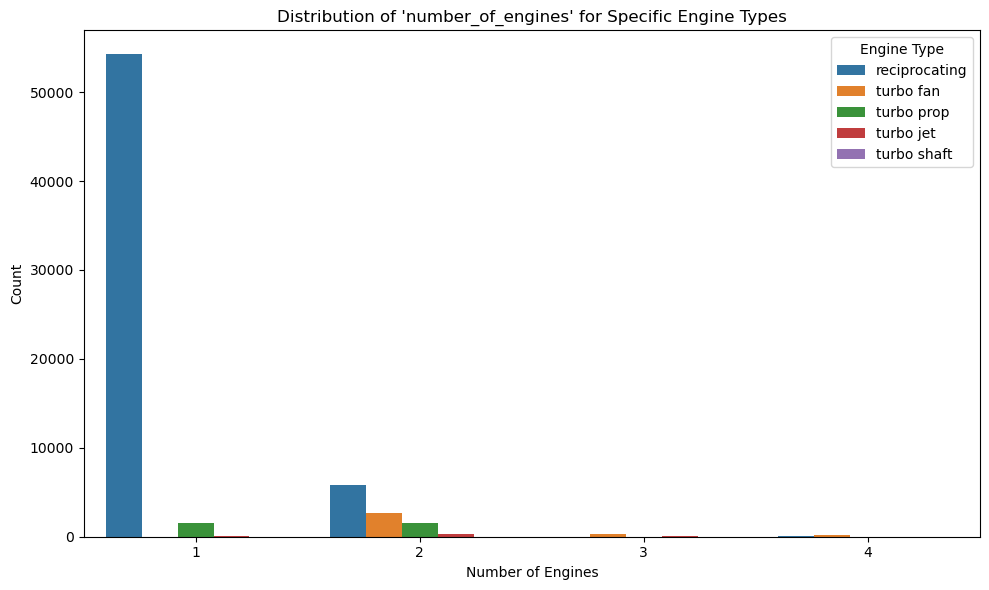

In [792]:
select_engines = ['reciprocating', 'turbo fan', 'turbo jet', 'turbo prop', 'turbo shaft']

# Filter the data for the specific 'engine_type' values and remove rows with missing values in the relevant columns
specific_engine_data = aviation_data[
    (aviation_data['engine_type'].isin(select_engines)) & 
    (aviation_data['aircraft_category'] == 'airplane') &
    aviation_data['number_of_engines'].notna() & 
    aviation_data['engine_type'].notna()
]
# Plot the distribution of 'number_of_engines' for the specific 'engine_type' values
plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_engines', hue='engine_type', data=specific_engine_data)
plt.title("Distribution of 'number_of_engines' for Specific Engine Types")
plt.xlabel("Number of Engines")
plt.ylabel("Count")
plt.legend(title='Engine Type')
plt.tight_layout()
plt.show()

This confirms both of our conclusions that a reciprocating engine, and a number of engines less than 2 are higher-risk.

Let's look at only the turbo fan.

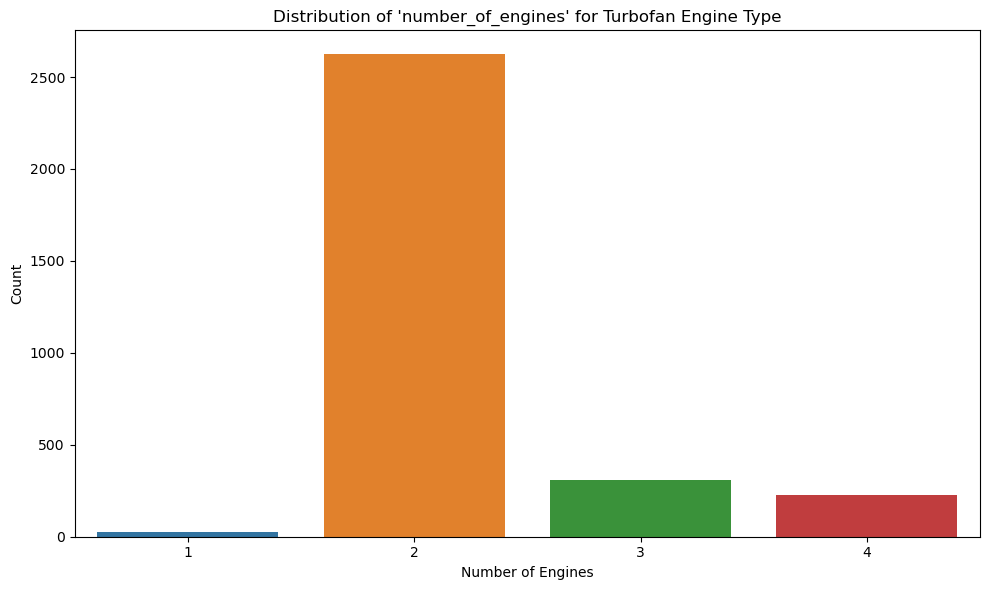

In [793]:
# Filter the data for the 'Turbofan' engine type
#turbofan_data = aviation_data[(aviation_data['engine_type'] == 'turbo fan') & (aviation_data['aircraft_category'] == 'airplane')]
turbofan_data = aviation_data[
    (aviation_data['engine_type'] == 'turbo fan') & 
    (aviation_data['aircraft_category'] == 'airplane') &
    aviation_data['number_of_engines'].notna()
]

# Plot the distribution of 'number_of_engines' for the 'Turbofan' engine type
plt.figure(figsize=(10, 6))
sns.countplot(x='number_of_engines', data=turbofan_data)
plt.title("Distribution of 'number_of_engines' for Turbofan Engine Type")
plt.xlabel("Number of Engines")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

reciprocating    14615
turbo shaft       1027
turbo prop        1011
turbo fan          329
turbo jet          150
none                 6
electric             2
hybrid rocket        1
Name: engine_type, dtype: int64

reciprocating      72726
turbo shaft         4138
turbo fan           3911
turbo prop          3825
turbo jet            740
none                  79
geared turbofan       15
electric              11
lr                     2
hybrid rocket          1
Name: engine_type, dtype: int64

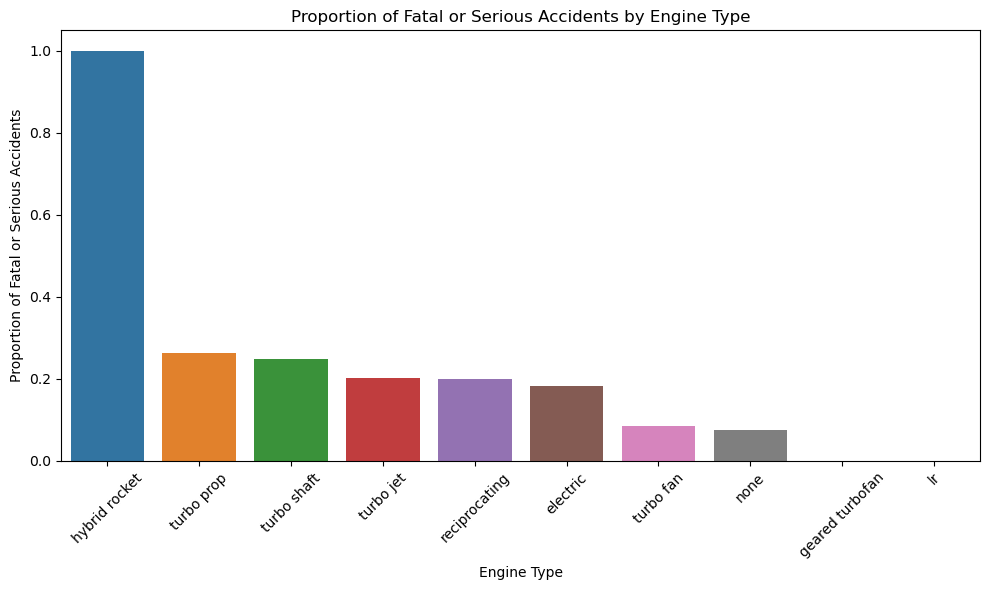

In [794]:
# Create a dataframe for fatal or serious accidents by engine type
fatal_serious_by_engine = aviation_data[aviation_data['severity_category'] == 'Fatal or Serious']
engine_type_counts = fatal_serious_by_engine['engine_type'].value_counts()
total_counts = aviation_data['engine_type'].value_counts()
display(engine_type_counts)
display(total_counts)

# Calculate the proportion of fatal or serious accidents
proportions = (engine_type_counts / total_counts).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=proportions.index, y=proportions.values)
plt.xlabel('Engine Type')
plt.ylabel('Proportion of Fatal or Serious Accidents')
plt.title('Proportion of Fatal or Serious Accidents by Engine Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion: Turbo Fan

It looks like we can reasonbly imply that the turbo fan is a great, low-risk option.

# Aircraft Make

Let's look more at aircraft make. Now that we have more information on engine type and count, let's look at what aircraft 'make's. Now that we're certain commercial flights are lowest-risk, we can filter based on commercial flights only.

In [795]:
commercial_flights['make'].unique()

array(['douglas', 'boeing', 'lockheed', 'hawker siddeley',
       'mcdonnell douglas', 'fokker', 'british aerospace', 'cessna',
       'fairchild', 'raytheon corporate jets', 'airbus', 'embraer',
       'saab-scania ab (saab)', 'canadair', 'gulfstream american corp',
       'saab', 'dassault', 'raytheon', 'bombardier', 'bombardier, inc.',
       'de havilland', 'bombardier inc', 'aerospatiale alenia',
       'embraer-empresa brasileira de', 'boeing of canada/dehav div',
       'atr', 'saab-scania', 'mcdonnell douglas aircraft co', 'antonov',
       'embraer s.a.', 'boeing company, long beach div', 'dehavilland',
       'embraer s a', 'boeing company', 'hawker',
       'mcdonnell douglas corporation', 'piper aircraft corporation',
       'harbin', 'diamond', 'spitfire', '737', 'united consultants'],
      dtype=object)

In [796]:
commercial_flights['make'].value_counts()

boeing                            150
airbus                             95
embraer                            62
bombardier inc                     52
mcdonnell douglas                  26
bombardier                         21
douglas                            10
de havilland                        8
mcdonnell douglas aircraft co       6
saab                                4
embraer s a                         4
embraer-empresa brasileira de       4
cessna                              3
bombardier, inc.                    3
737                                 2
british aerospace                   2
fokker                              2
saab-scania ab (saab)               2
canadair                            2
atr                                 2
boeing company                      2
hawker                              1
piper aircraft corporation          1
mcdonnell douglas corporation       1
boeing company, long beach div      1
harbin                              1
diamond     

### Filtering by Number of Engines

Since we've determined that having 2 or more engines is lower-risk, we can filter out all of the airplane makes with an engine number less than 2.

In [797]:
commercial_flights = commercial_flights[commercial_flights['number_of_engines'] >= 2]

commercial_flights['make'].value_counts()

boeing                           132
airbus                            92
embraer                           61
bombardier inc                    51
mcdonnell douglas                 22
bombardier                        17
douglas                            9
de havilland                       8
mcdonnell douglas aircraft co      6
embraer-empresa brasileira de      4
saab                               4
embraer s a                        4
bombardier, inc.                   3
atr                                2
boeing company                     2
saab-scania ab (saab)              2
dehavilland                        1
embraer s.a.                       1
mcdonnell douglas corporation      1
antonov                            1
fairchild                          1
aerospatiale alenia                1
saab-scania                        1
boeing of canada/dehav div         1
british aerospace                  1
lockheed                           1
dassault                           1
g

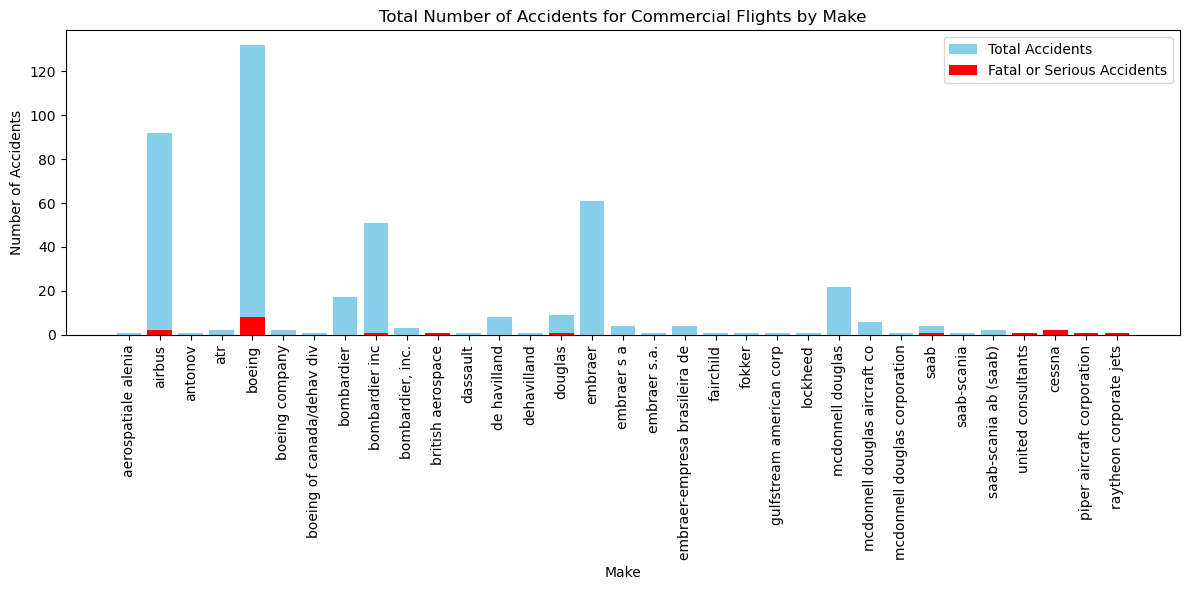

In [798]:
# Group the data by 'make' and calculate the total number of accidents and 'Fatal or Serious' accidents
accidents_by_make_commercial = commercial_flights.groupby('make').size().reset_index(name='total_accidents')
fatal_serious_by_make_commercial = commercial_fatal_serious.groupby('make').size().reset_index(name='total_fatal_serious')

# Merge the total accidents and 'Fatal or Serious' accidents dataframes on 'make'
merged_data_commercial = pd.merge(accidents_by_make_commercial, fatal_serious_by_make_commercial, on='make', how='outer')

# Plot the stacked bar graph
plt.figure(figsize=(12, 6))
plt.bar(merged_data_commercial['make'], merged_data_commercial['total_accidents'], color='skyblue', label='Total Accidents')
plt.bar(merged_data_commercial['make'], merged_data_commercial['total_fatal_serious'], color='red', label='Fatal or Serious Accidents')
plt.title('Total Number of Accidents for Commercial Flights by Make')
plt.xlabel('Make')
plt.ylabel('Number of Accidents')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Normalizing

To account for the fact that there is more data for certain makes such as 'boeing', but they might not actually be of higher-risk...Let's normalize the number of 'Fatal or Serious' accidents by the total number of accidents for each 'make'.

In [799]:
#ensure no 0's to avoid division by 0
merged_df_ac['total_accidents_ac'].value_counts()

67928    1
464      1
881      1
200      1
7236     1
92       1
1        1
32       1
16       1
162      1
Name: total_accidents_ac, dtype: int64

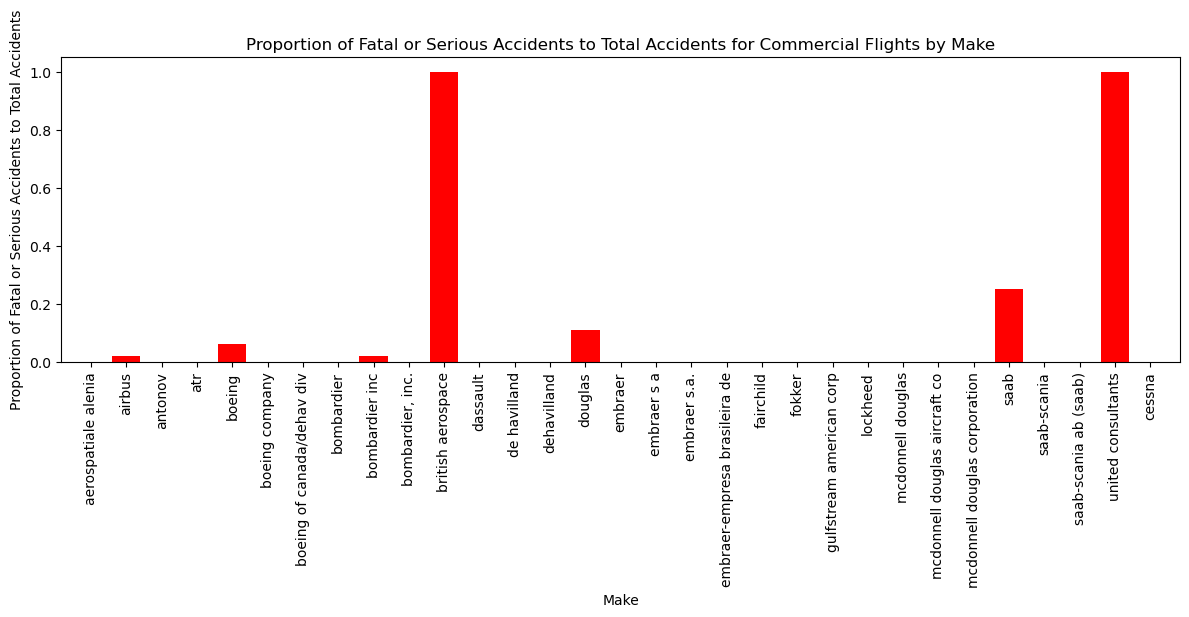

In [800]:
# Calculate the proportion of 'Fatal or Serious' accidents relative to total accidents for each 'make'
merged_data_commercial['fatal_to_total_ratio'] = merged_data_commercial['total_fatal_serious'] / merged_data_commercial['total_accidents']

# Plot the bar graph of the 'fatal_to_total_ratio' for each 'make'
plt.figure(figsize=(12, 6))
plt.bar(merged_data_commercial['make'], merged_data_commercial['fatal_to_total_ratio'], color='red')
plt.title('Proportion of Fatal or Serious Accidents to Total Accidents for Commercial Flights by Make')
plt.xlabel('Make')
plt.ylabel('Proportion of Fatal or Serious Accidents to Total Accidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Visualization of safest commercial makes >= year 2000

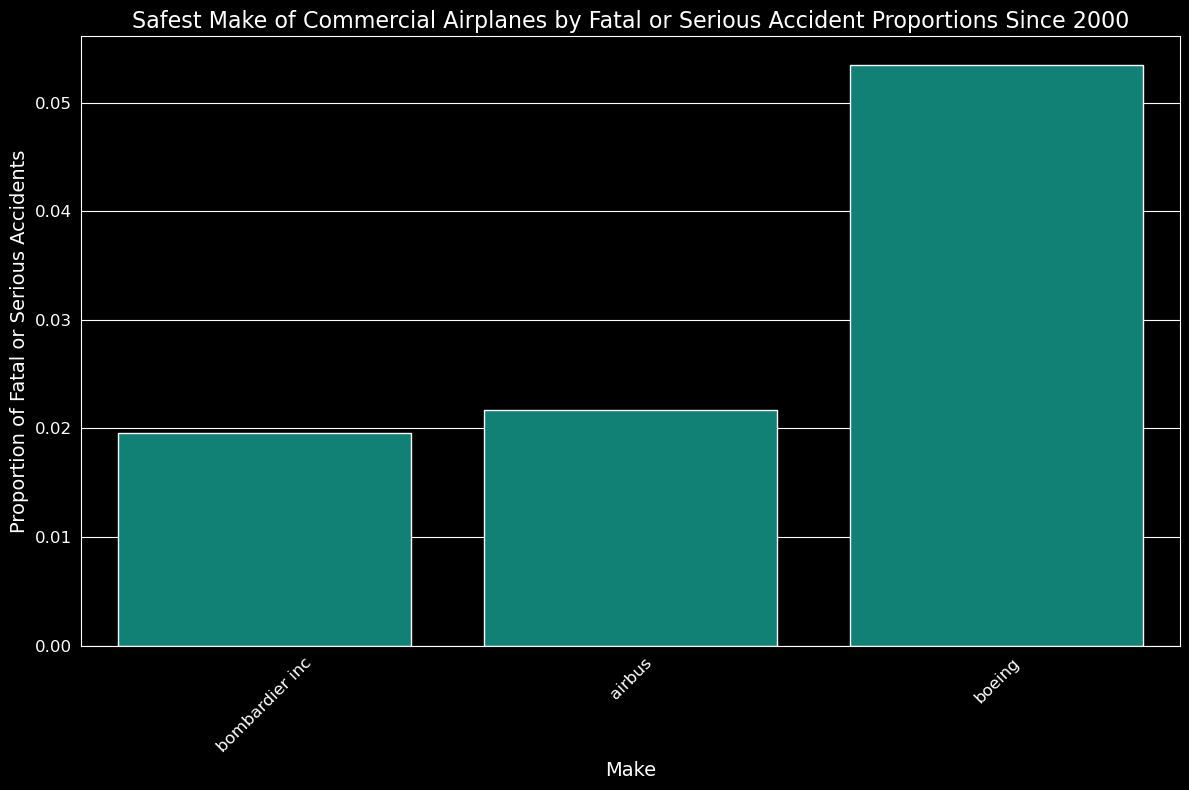

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [801]:
# Filter out data older than 2000
filtered_flights = commercial_flights[(commercial_flights['year'] >= 2000)]

# Calculate the proportion of fatal or serious accidents for each make
total_accidents = filtered_flights.groupby('make').size()
# Filter out makes with less than 10 accidents for reliability
total_accidents = total_accidents[total_accidents > 5]
fatal_serious_accidents = filtered_flights[filtered_flights['severity_category'] == 'Fatal or Serious'].groupby('make').size()
fatal_serious_accidents = fatal_serious_accidents.reindex(total_accidents.index, fill_value=0)

# Calculate the proportions
safety_proportions = (fatal_serious_accidents / total_accidents).sort_values()

# Filter out zero values
safety_proportions = safety_proportions[safety_proportions > 0].dropna()

# Get the top 10 safest makes
top_10_safest = safety_proportions.head(10)

# Plotting
plt.figure(figsize=(12, 8), facecolor='black')
sns.set_style("darkgrid", {"axes.facecolor": "black"})
sns.barplot(x=top_10_safest.index, y=top_10_safest.values, palette=['#009384'])
plt.title('Safest Make of Commercial Airplanes by Fatal or Serious Accident Proportions Since 2000', fontsize=16, color='white')
plt.xlabel('Make', fontsize=14, color='white')
plt.ylabel('Proportion of Fatal or Serious Accidents', fontsize=14, color='white')
plt.xticks(rotation=45, fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.tight_layout()

# Save the figure with a transparent background
plt.savefig('images/safest_airplanes.png', transparent=True)

# Show the plot in the notebook with black background
plt.show()

plt.figure(figsize=(12, 8), facecolor='white')


## Boeing and Airbus

Comparing our graphs before and after normalization gives some amazing insight. In the first "non-normalized" graph, our two makes with the highest number of accidents are **Boeing** and **Airbus**. However once we *normalized* the data, the *opposite* became true. This confirms that Boeing and Airbus are two of our safest airplane makes! They have the greatest value counts in our commercial data (and are therefore used frequently by the commercial airplanes we've determined are lowest-risk), yet their porportion of 'fatal or serious' accidents is near zero!

Let's examine these a little further.

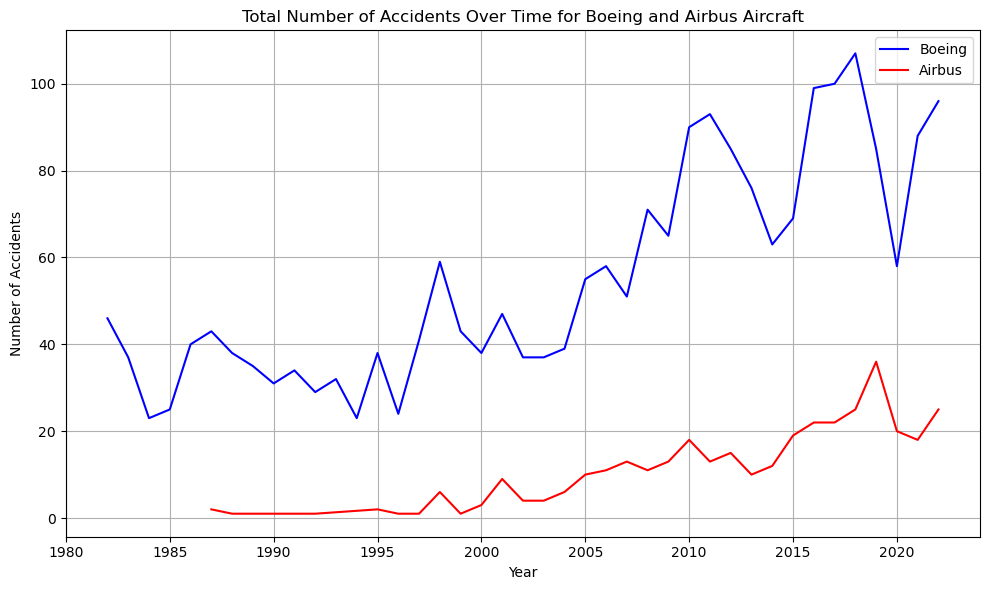

In [620]:
plt.style.use('default')

# Filter the data for Boeing and Airbus aircraft
boeing_data = aviation_data[(aviation_data['make'] == 'boeing') & (aviation_data['aircraft_category'] == 'airplane')]
airbus_data = aviation_data[(aviation_data['make'] == 'airbus') & (aviation_data['aircraft_category'] == 'airplane')]

# Group the filtered data by year and calculate the total number of accidents for each year
boeing_accidents_by_year = boeing_data.groupby(boeing_data['event_date'].dt.year).size()
airbus_accidents_by_year = airbus_data.groupby(airbus_data['event_date'].dt.year).size()

# Plot the total number of accidents over time for Boeing and Airbus
plt.figure(figsize=(10, 6))
plt.plot(boeing_accidents_by_year.index, boeing_accidents_by_year.values, label='Boeing', color='blue')
plt.plot(airbus_accidents_by_year.index, airbus_accidents_by_year.values, label='Airbus', color='red')

plt.title('Total Number of Accidents Over Time for Boeing and Airbus Aircraft')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualization: Normalized Total Number of Accidents Over Time

The following plot shows the normalized total number of accidents over time for Boeing and Airbus aircraft. This helps us understand trends in accident rates and identify any significant changes over time.

Let's normalize the data, in case there are great variets in value coutns per year.

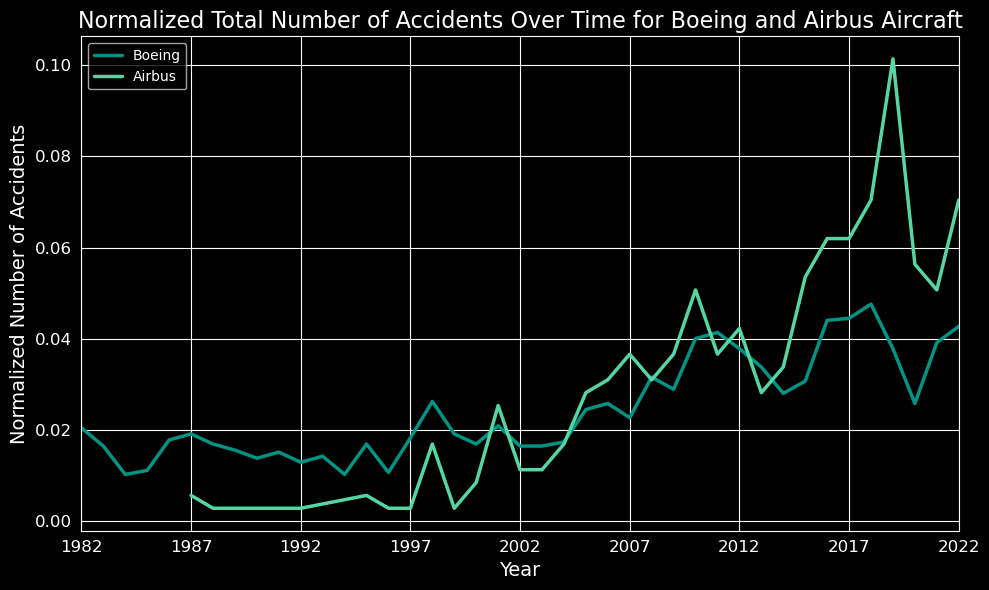

In [628]:
# Set the black background and white font
plt.style.use('dark_background')

# Normalize the data for each make
boeing_accidents_normalized = boeing_accidents_by_year / boeing_accidents_by_year.sum()
airbus_accidents_normalized = airbus_accidents_by_year / airbus_accidents_by_year.sum()

# Plot the normalized total number of accidents over time for Boeing and Airbus
plt.figure(figsize=(10, 6), facecolor='black')
#gives us sns dark colors
sns.set_style("darkgrid", {"axes.facecolor": "black"})
plt.plot(boeing_accidents_normalized.index, boeing_accidents_normalized.values, label='Boeing', color='#009384', linewidth=2.5)
plt.plot(airbus_accidents_normalized.index, airbus_accidents_normalized.values, label='Airbus', color='#57D4A3', linewidth=2.5)

plt.title('Normalized Total Number of Accidents Over Time for Boeing and Airbus Aircraft', fontsize=16, color='white')
plt.xlabel('Year', fontsize=14, color='white')
plt.ylabel('Normalized Number of Accidents', fontsize=14, color='white')
plt.legend(fontsize=12, facecolor='black', edgecolor='black', framealpha=0)
plt.setp(plt.legend().get_texts(), color='white')
plt.grid(True)
plt.xticks(range(1982, 2023, 5), fontsize=12, color='white')  # Set ticks every 5 years
plt.yticks(fontsize=12, color='white')
plt.xlim(1982, 2022)
plt.tight_layout()

# Transparent BG that Joseph mentioned!
plt.savefig('images/boeing_vs_airbus.png', transparent=True)

# Show the plot
plt.show()

# Reset the style to default for subsequent plots
plt.style.use('default')

In [629]:
# Create a DataFrame for exporting to CSV
# Align the indices
normalized_data = pd.DataFrame({
    'Year': boeing_accidents_normalized.index.union(airbus_accidents_normalized.index),
    'Boeing_Normalized': boeing_accidents_normalized.reindex(boeing_accidents_normalized.index.union(airbus_accidents_normalized.index)).values,
    'Airbus_Normalized': airbus_accidents_normalized.reindex(boeing_accidents_normalized.index.union(airbus_accidents_normalized.index)).values
})

# Export the normalized data to a CSV file
csv_file_path = 'tableau_data/normalized_total_number_of_accidents_over_time_for_boeing_and_airbus_aircraft.csv'
normalized_data.to_csv(csv_file_path, index=False)

## Conclusion: Boeing (Runner Up: Airbus)

Wow!!! That changed a lot!!! Clearly, Boeing is the safer option over Airbus, at least in recent years. We'll keep Airbus as a runner up, since it seems like another great low-risk option, compared to other commercial airplane makes.

#### Bonus: Model

Let's look at the stats on the models for these two aircraft make/manufacturers!

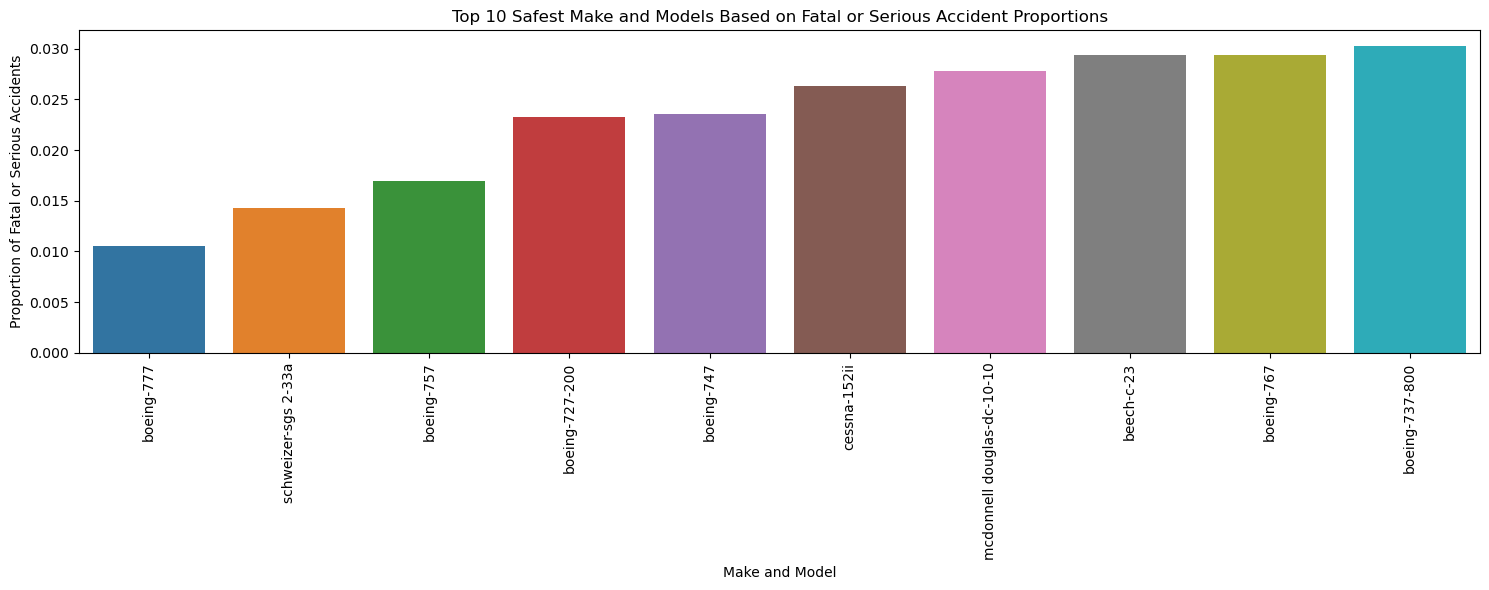

In [636]:

total_accidents = aviation_data.groupby('make_model').size()
#lets not look at low accident count models due to a lack of data
#we don't want to crank it up too far tho b/c the safest planes might not have many accidents!
total_accidents = total_accidents[total_accidents > 5]

#Calculate the number of fatal or serious accidents for each make and model
fatal_serious_accidents = aviation_data[aviation_data['severity_category'] == 'Fatal or Serious'].groupby('make_model').size()
#fill with np.nan so that we don't to deal with 0 fatal accident aircraft
#we do this to filter out those lacking enough data
fatal_serious_accidents = fatal_serious_accidents.reindex(total_accidents.index, fill_value=np.nan)

#Calculate the proportion of fatal or serious accidents for each make and model
safety_proportions = (fatal_serious_accidents / total_accidents).sort_values()

plt.figure(figsize=(15, 6))
sns.barplot(x=safety_proportions.head(10).index, y=safety_proportions.head(10).values)
plt.title('Top 10 Safest Make and Models Based on Fatal or Serious Accident Proportions')
plt.xlabel('Make and Model')
plt.ylabel('Proportion of Fatal or Serious Accidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


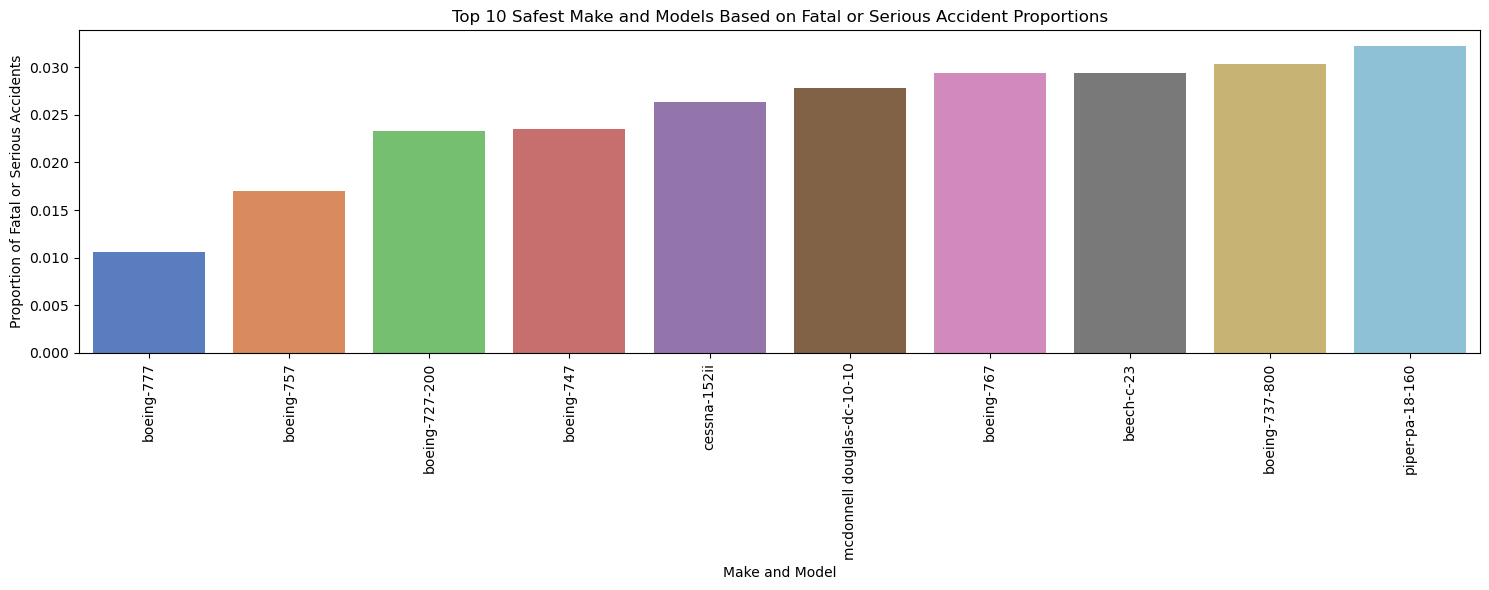

In [642]:
# Filter the data for commercial flights and airplanes
commercial_flights_new = aviation_data[(aviation_data['aircraft_category'] == 'airplane')]

# Group the data by make_model and calculate the total number of accidents for each make_model
total_accidents = commercial_flights_new.groupby('make_model').size()

# Filter out make_models with less than 5 accidents for reliability
total_accidents = total_accidents[total_accidents > 5]

# Calculate the number of fatal or serious accidents for each make and model
fatal_serious_accidents = commercial_flights_new[commercial_flights_new['severity_category'] == 'Fatal or Serious'].groupby('make_model').size()

# Fill with np.nan so that we don't have to deal with 0 fatal accident aircraft
fatal_serious_accidents = fatal_serious_accidents.reindex(total_accidents.index, fill_value=np.nan)

# Calculate the proportion of fatal or serious accidents for each make and model
safety_proportions = (fatal_serious_accidents / total_accidents).sort_values()

# Plot the top 10 safest make and models based on fatal or serious accident proportions
plt.figure(figsize=(15, 6))
sns.barplot(x=safety_proportions.head(10).index, y=safety_proportions.head(10).values, palette='muted')
plt.title('Top 10 Safest Make and Models Based on Fatal or Serious Accident Proportions')
plt.xlabel('Make and Model')
plt.ylabel('Proportion of Fatal or Serious Accidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


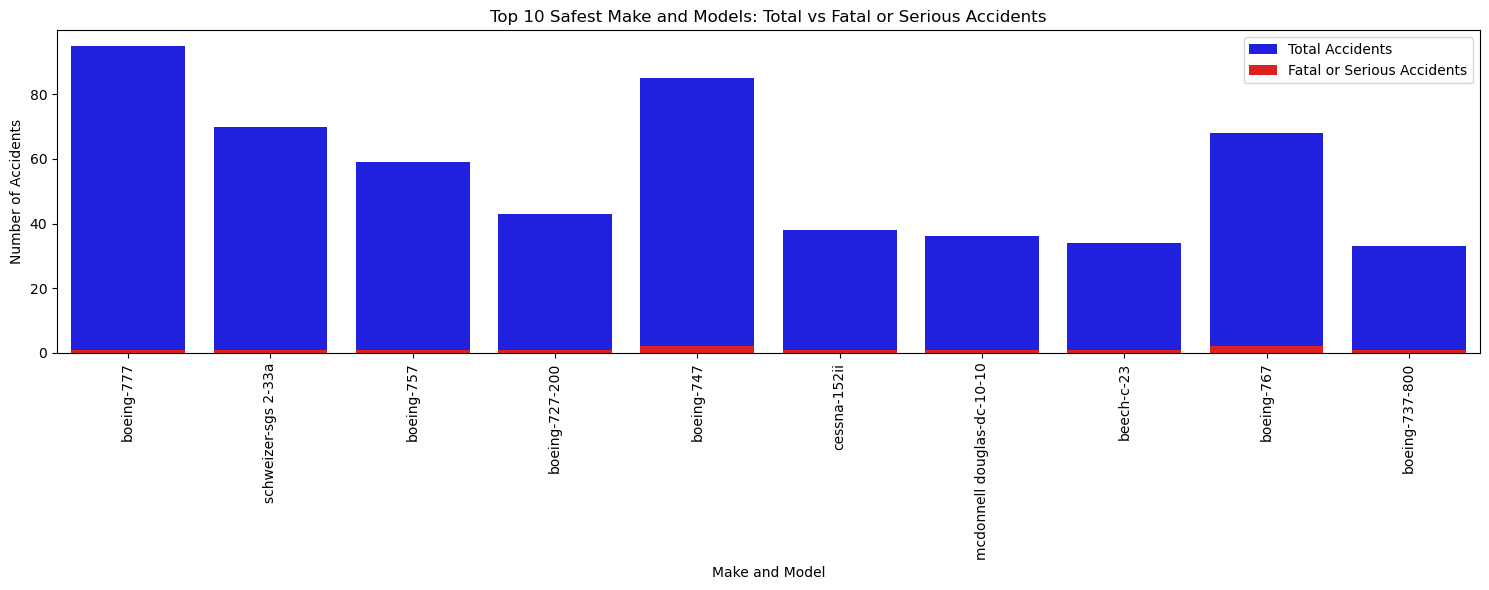

In [632]:

top_10_safest = safety_proportions.head(10).index

top_10_total_accidents = total_accidents.loc[top_10_safest]
top_10_fatal_serious_accidents = fatal_serious_accidents.loc[top_10_safest]

plt.figure(figsize=(15, 6))

sns.barplot(x=top_10_total_accidents.index, y=top_10_total_accidents.values, color='b', label='Total Accidents')
sns.barplot(x=top_10_fatal_serious_accidents.index, y=top_10_fatal_serious_accidents.values, color='r', label='Fatal or Serious Accidents')

plt.title('Top 10 Safest Make and Models: Total vs Fatal or Serious Accidents')
plt.xlabel('Make and Model')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion On Make and model

The Boeing 777 is the safest in terms of having the least amount of fatal or serious accidents compared to the total number of accidents after filtering out those that don't have enough data.

# Final Conclusions

We defined low-risk as the lowest risk to human life and the metric we used for that is the relative fatal or serious to total number of accidents ratio for each feature.  This let us normalize and compare different features even if some of them have far more data, such as the fact private has far more accidents than commercial.

Here are the results of our questions gained from business understanding:

## Aircraft Category: Airplane
The best low-risk option of aircraft for both private and commercial use is an airplane. 
## Private or Commercial: Commercial
The best low-risk purpose of business for airplane usage is commercial flights.
## Features: 2 Engines, Turbofan
The best features to include in your airplane model to ensure a low-risk of accidents, are 2 or more engines of ideally a turbo-fan type. 
## Make: Boeing (Airbus: Runner Up)
The manufacturer to purchase aircraft from for the most risk-safe product is Boeing, with Airbus as a runner up.
## Make and Model: Boeing-777
The model 777 from Boeing in this data set has the lowest proprotion of serious and fatal accidents to total accidents after filtering planes that do not have enough data.

## Summary of Findings

1. **Aircraft Category:** Airplanes are the safest category of aircraft.
2. **Purpose of Flight:** Commercial flights are generally safer than private flights.
3. **Aircraft Features:** Aircraft with 2 or more engines and turbo-fan engines are associated with lower risk.
4. **Aircraft Manufacturers:** Boeing and Airbus are the safest manufacturers, with Boeing being the safest overall.
5. **Specific Models:** The Boeing 777 is the safest model based on our analysis.

These findings will guide our business recommendations for purchasing and operating low-risk aircraft.


## Interactive Dashboard

An interactive dashboard has been created to explore the data and visualize key insights interactively. This dashboard allows the viewer to filter and analyze different aspects of the dataset, making it easier to understand the factors contributing to aircraft safety.

[Interactive Dashboard Link](https://public.tableau.com/app/profile/chisum.lindauer/viz/Flatiron-Project1-Visualizations-final/Dashboard1?publish=yes(learn-env))
